In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

# data setting

## **데이터** 불러오기 + unpickle 준비

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
a = unpickle("/content/drive/MyDrive/cifar-100-python/train")
label_name = unpickle("/content/drive/MyDrive/cifar-100-python/meta")
label_name = [l.decode('utf8') for l in label_name[b'fine_label_names']]
print(a.keys())


dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


## dataset

In [14]:
from torch.utils.data import Dataset


class cifar100trainDataset(Dataset):
  def __init__(self, val = False, transform = None, val_percentage = 0.1):
    tdata = unpickle("/content/drive/MyDrive/cifar-100-python/train")
    valArrange = int(len(tdata[b'fine_labels'])*val_percentage)
    if val:
      self.data = {b'data':tdata[b'data'][:valArrange],
                   b'fine_labels':tdata[ b'fine_labels'][:valArrange],
                   b'coarse_labels':tdata[b'coarse_labels'][:valArrange]
                   }
    else:
      self.data = {b'data':tdata[b'data'][valArrange:],
                   b'fine_labels':tdata[ b'fine_labels'][valArrange:],
                   b'coarse_labels':tdata[b'coarse_labels'][valArrange:]
                   }


    meta = unpickle("/content/drive/MyDrive/cifar-100-python/meta")
    self.label_name = [l.decode('utf8') for l in meta[b'fine_label_names']]

    self.transform = transform


  def __len__(self):
    return len(self.data[b'data'])

  def __getitem__(self, idx):

    img = self.data[b'data'][idx]
    lb = self.data[b'fine_labels'][idx]
    lb_name = self.label_name[lb]
    img = img.reshape(3,32,32).transpose((1,2,0))

    if self.transform:
      img = self.transform(img)

    return img, lb, lb_name

In [15]:
from torchvision import transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

tensor([[[-0.0039, -0.1686, -0.3176,  ..., -0.4510, -0.3725, -0.2392],
         [-0.1765, -0.2941, -0.4039,  ..., -0.4902, -0.4588, -0.3333],
         [-0.3647, -0.4980, -0.5059,  ..., -0.4588, -0.3725, -0.3176],
         ...,
         [ 0.3804,  0.0824,  0.0980,  ..., -0.1843,  0.0353,  0.3020],
         [ 0.3569,  0.2078,  0.1373,  ..., -0.1686,  0.0745,  0.1137],
         [ 0.2314,  0.0980,  0.2863,  ..., -0.0039,  0.1294,  0.1686]],

        [[-0.1373, -0.2392, -0.4039,  ..., -0.5529, -0.4353, -0.2471],
         [-0.3098, -0.3725, -0.4824,  ..., -0.5608, -0.4902, -0.3098],
         [-0.5059, -0.5686, -0.5765,  ..., -0.5137, -0.3882, -0.2863],
         ...,
         [ 0.2078, -0.1216, -0.1765,  ..., -0.3882, -0.1843,  0.0431],
         [ 0.1294, -0.0667, -0.1843,  ..., -0.3490, -0.1059, -0.0745],
         [-0.0118, -0.1922, -0.0353,  ..., -0.1451, -0.0039,  0.0353]],

        [[-0.1843, -0.2314, -0.3647,  ..., -0.5137, -0.4588, -0.3569],
         [-0.3490, -0.3569, -0.4667,  ..., -0

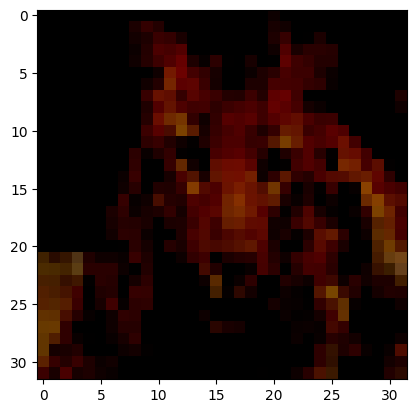

In [16]:
data = cifar100trainDataset(val = False, transform = transform)

print(data[0][0])

sample = data[0][0].numpy()
print(sample.shape)
sample = np.transpose(sample, (1,2,0))
height, width, _ = sample.shape
plt.imshow(sample)
print(height, width)
print(data[0][1])

# mobileNet

## model

In [17]:
class mobileNet(nn.Module):
  def __init__(self):
    super(mobileNet, self).__init__()
    model_achi = [['conv',(3,32,3,2)],['convdw',(32,32,3,1)],
                ['conv',(32,64,1,1)],['convdw',(64,64,3,2)],

                 ['conv',(64,128,1,1)],['convdw',(128,128,3,1)],
                ['conv',(128,128,1,1)],['convdw',(128,128,3,2)],

                 ['conv',(128,256,1,1)],['convdw',(256,256,3,1)],
                ['conv',(256,256,1,1)],['convdw',(256,256,3,2)],

                 ['conv', (256,512,1,1)]]
    for i in range(5):
      model_achi += [['convdw',(512,512,3,1)],['conv',(512,512,1,1)]]

    model_achi += [['convdw',(512,512,3,2)],['conv',(512,1024,1,1)],
                  ['convdw',(1024,1024,3,2)],['conv',(1024,1024,1,1)],

                  ['avgpool']]


    self.fc = nn.Linear(1024,100)

    self.softmax = nn.Softmax()

    self.model_layers = self._make_layer(model_achi)

  def _make_layer(self, model_achi):
    layers = []
    for ma in model_achi:
      if ma[0] == 'conv':
        layers += [nn.Conv2d(in_channels = ma[1][0],
                             out_channels = ma[1][1],
                             kernel_size = ma[1][2],
                             stride = ma[1][3],
                             padding_mode = 'zeros'
                             ),
                   nn.BatchNorm2d(ma[1][1]),
                   nn.ReLU(inplace = True)]
      elif ma[0] == 'convdw':
        layers += [nn.Conv2d(in_channels = ma[1][0],
                             out_channels = ma[1][1],
                             kernel_size = ma[1][2],
                             stride = ma[1][3],
                             padding = 1,
                             groups = ma[1][1]
                             ),
                   nn.BatchNorm2d(ma[1][1]),
                   nn.ReLU(inplace = True)]
      elif ma[0] == 'avgpool':
        layers += [nn.AdaptiveAvgPool2d((1, 1))]

    return nn.Sequential(*layers)


  def forward(self, x):
    x = self.model_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return self.softmax(x)

## train

In [18]:
trainDataset = cifar100trainDataset(val = False, transform = transform)
valDataset = cifar100trainDataset(val = True, transform = transform)

train_loader = torch.utils.data.DataLoader(trainDataset, batch_size = 64,
                                    shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(valDataset,
                                    shuffle = True, num_workers = 2)
#===
import torch.optim as optim


model = mobileNet()
model = model.to(device)


optimizer = optim.SGD(model.parameters(), lr = 0.4)
criterion = nn.CrossEntropyLoss()


### trained

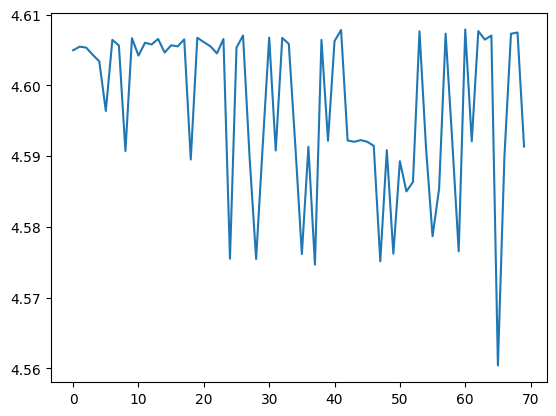

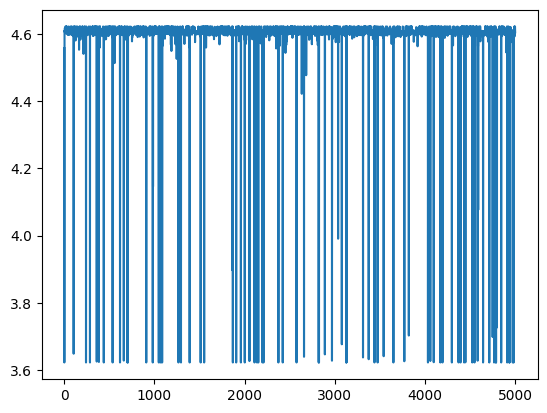

epoch : 0 , acc :  0.0292


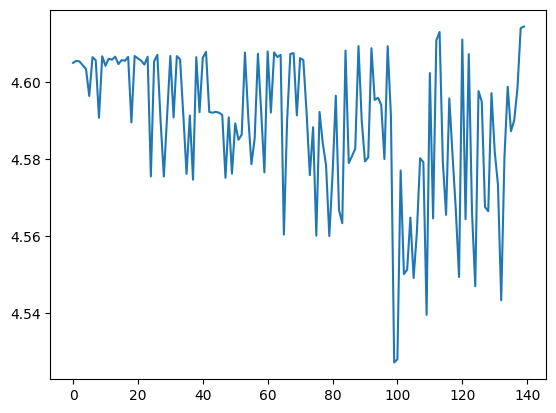

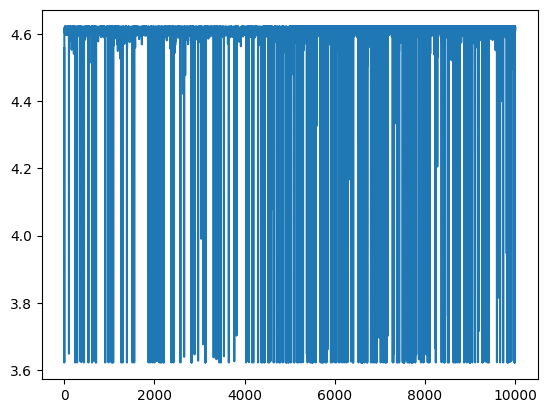

epoch : 1 , acc :  0.0414


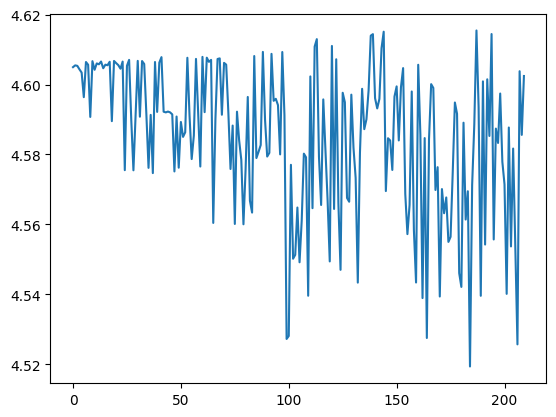

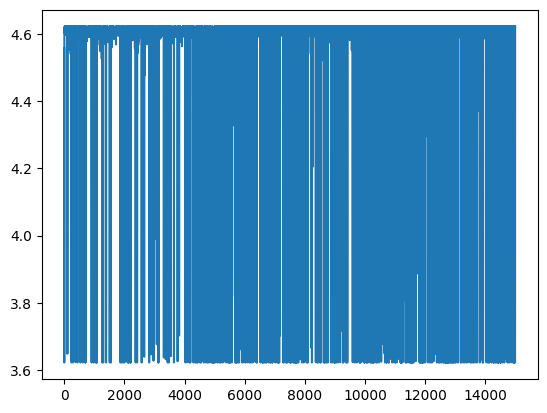

epoch : 2 , acc :  0.0474


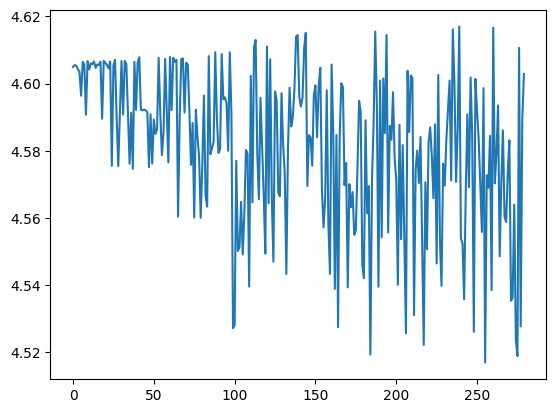

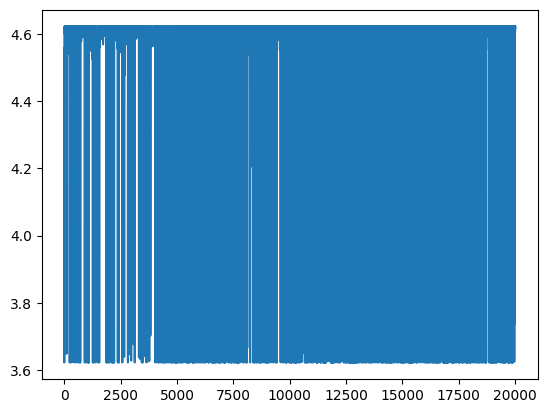

epoch : 3 , acc :  0.0534


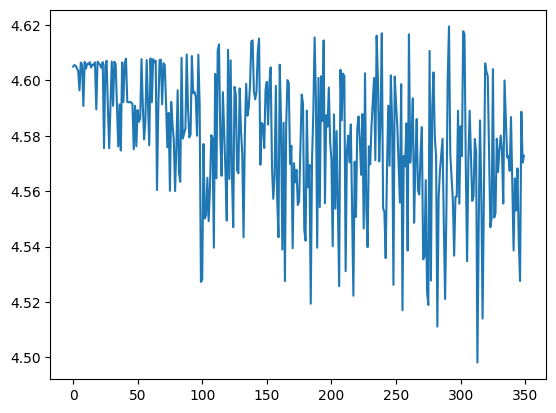

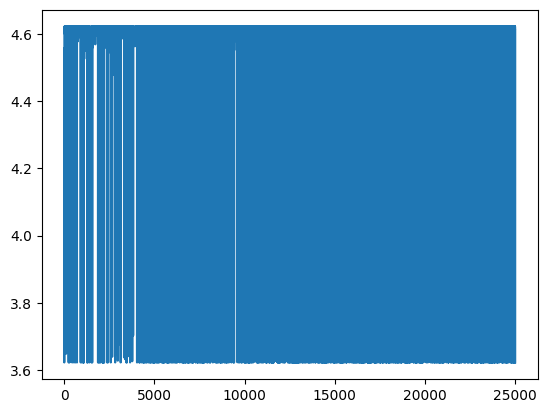

epoch : 4 , acc :  0.0518


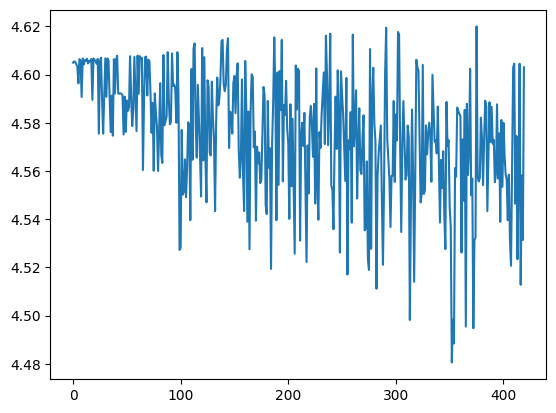

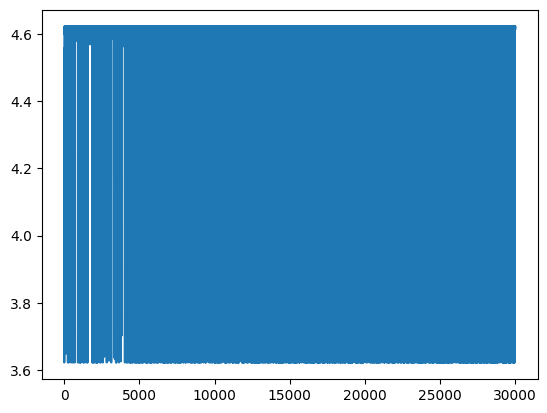

epoch : 5 , acc :  0.0564


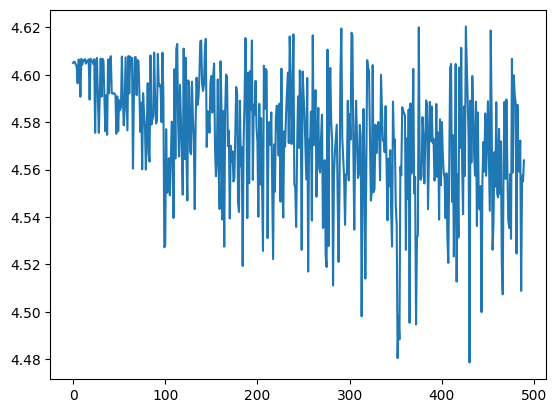

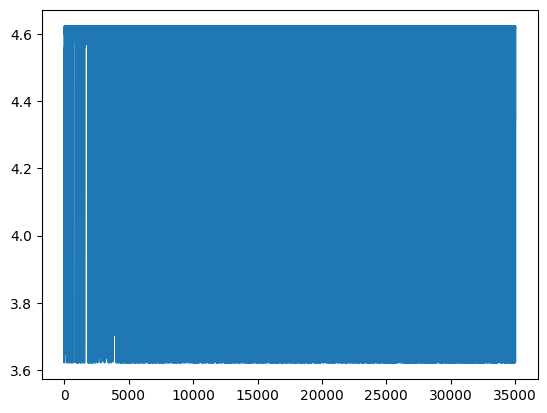

epoch : 6 , acc :  0.0572


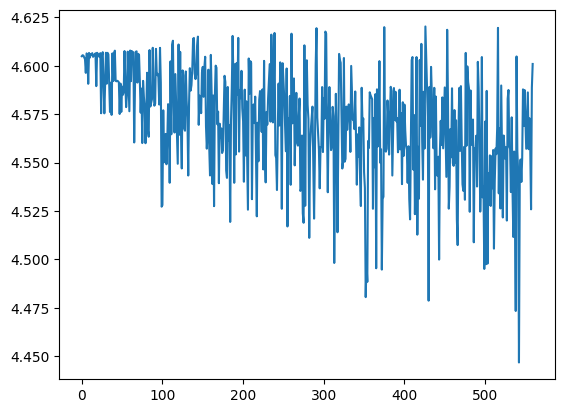

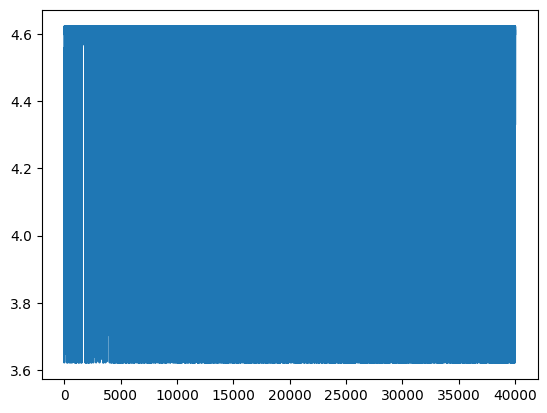

epoch : 7 , acc :  0.058


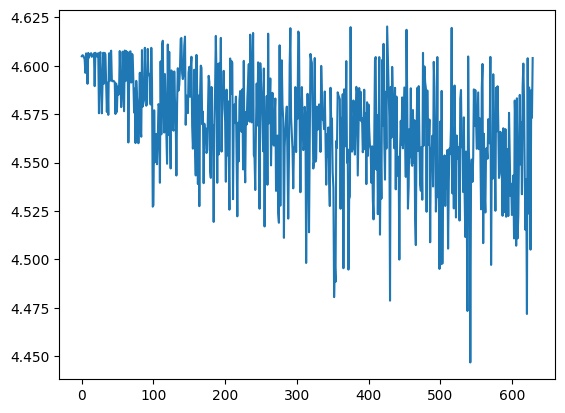

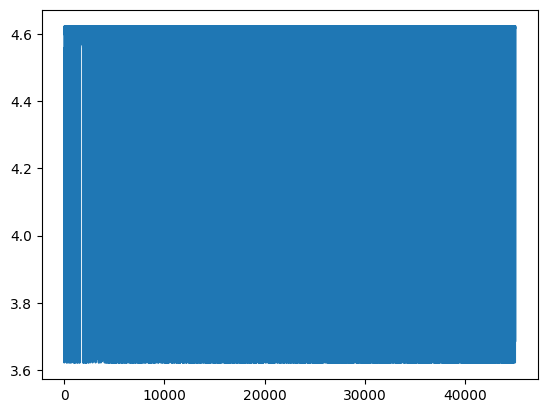

epoch : 8 , acc :  0.0664


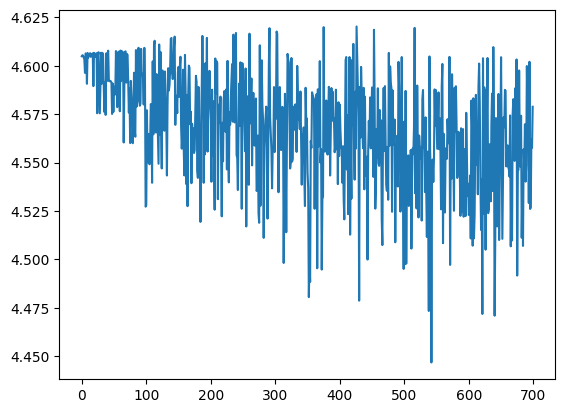

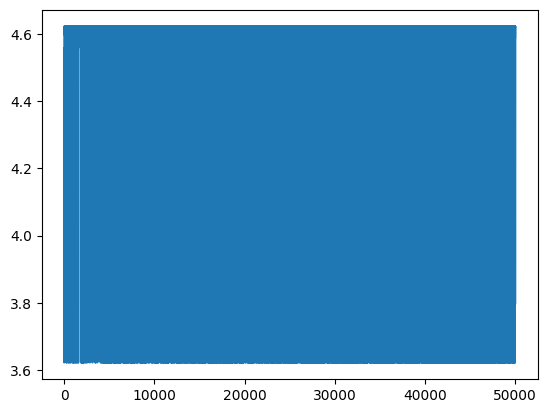

epoch : 9 , acc :  0.058


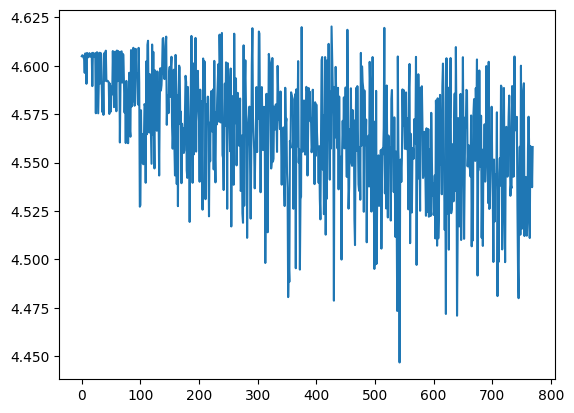

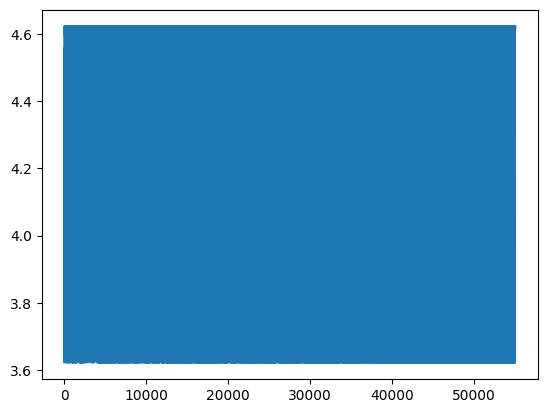

epoch : 10 , acc :  0.0668


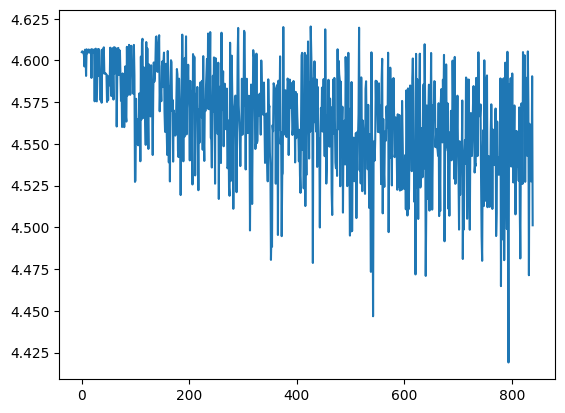

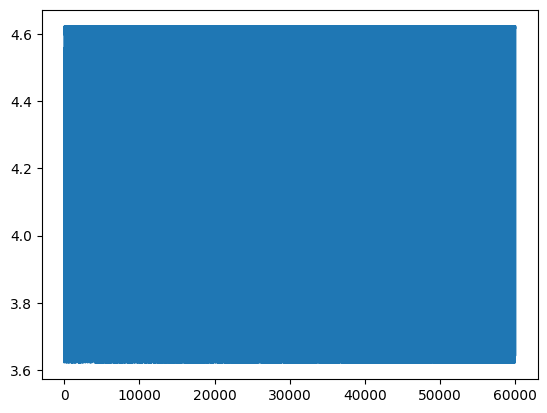

epoch : 11 , acc :  0.0738


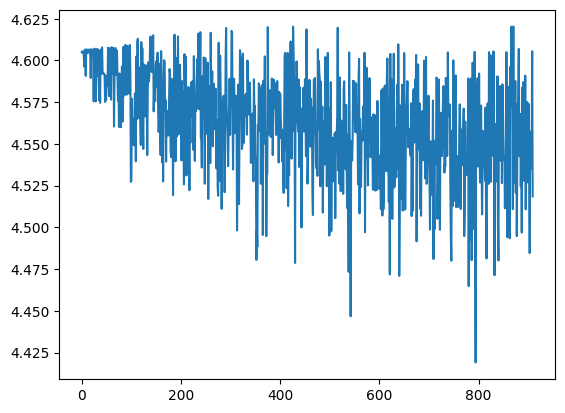

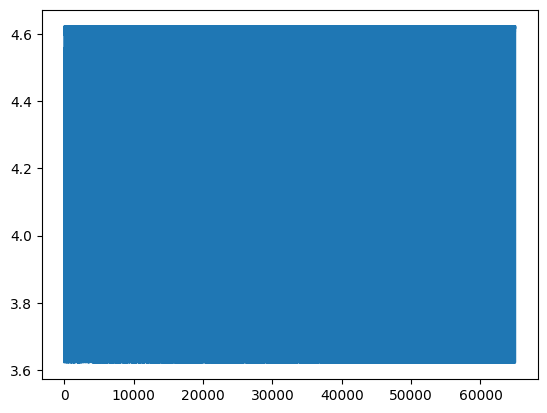

epoch : 12 , acc :  0.0818


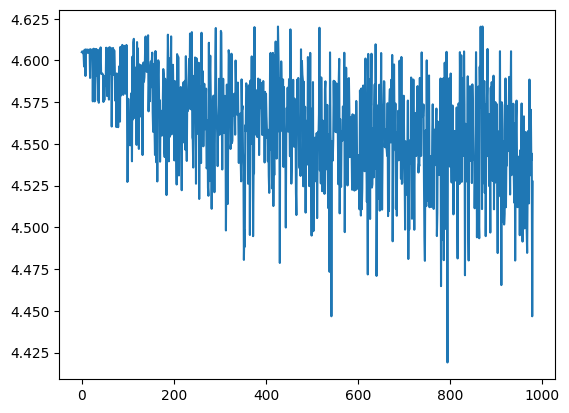

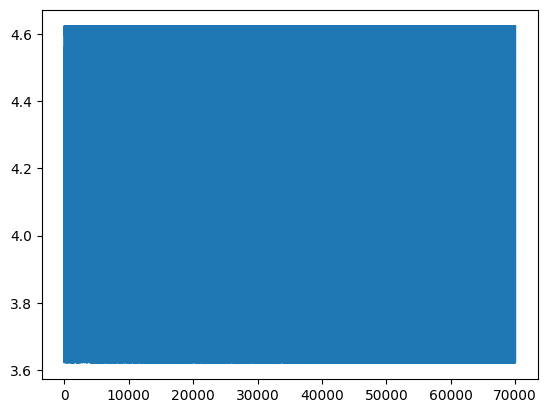

epoch : 13 , acc :  0.0802


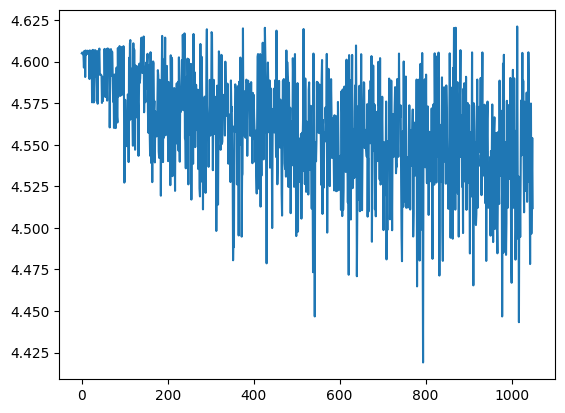

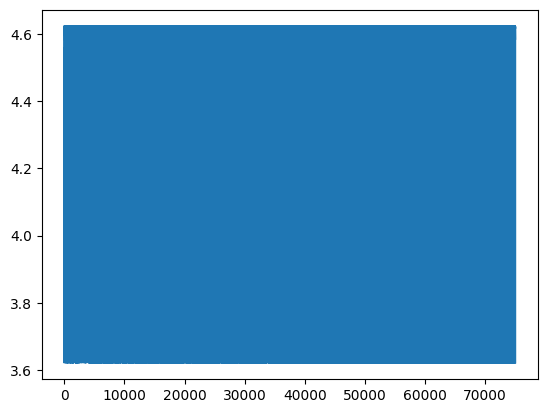

epoch : 14 , acc :  0.0834


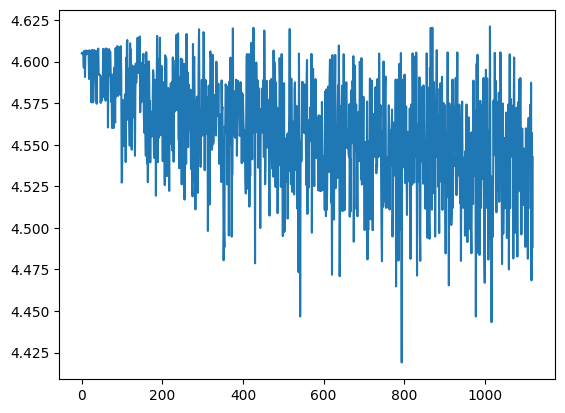

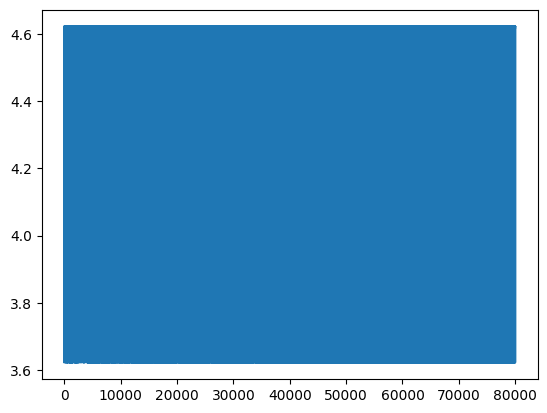

epoch : 15 , acc :  0.0812


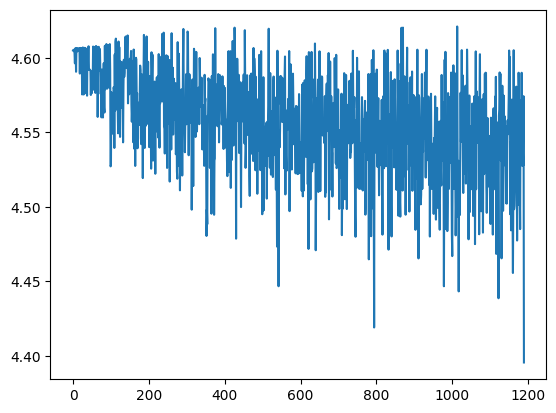

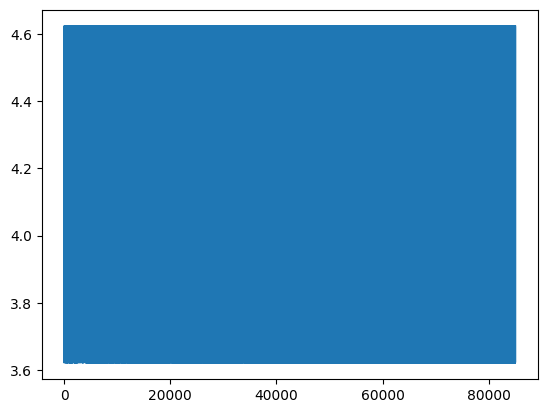

epoch : 16 , acc :  0.0868


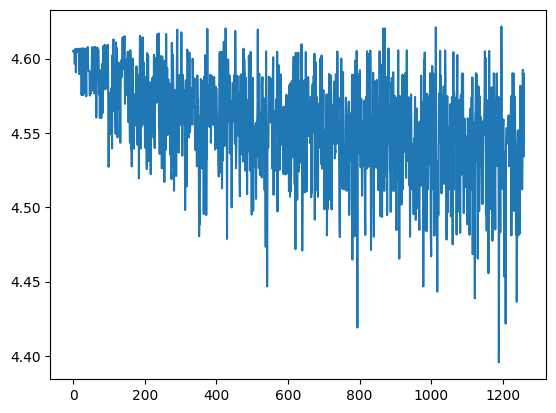

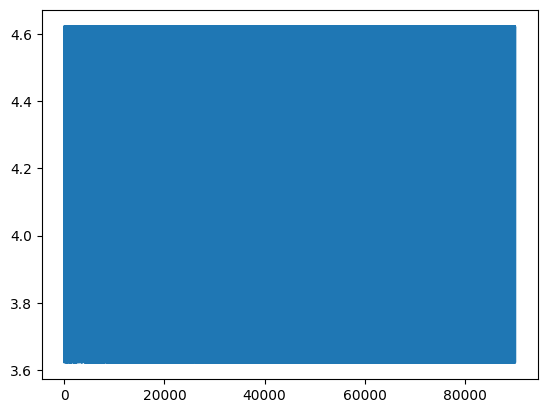

epoch : 17 , acc :  0.0782


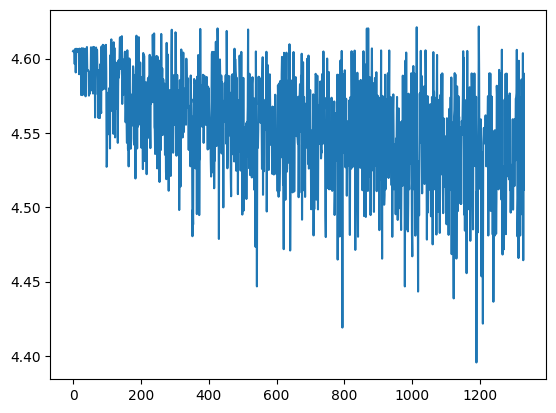

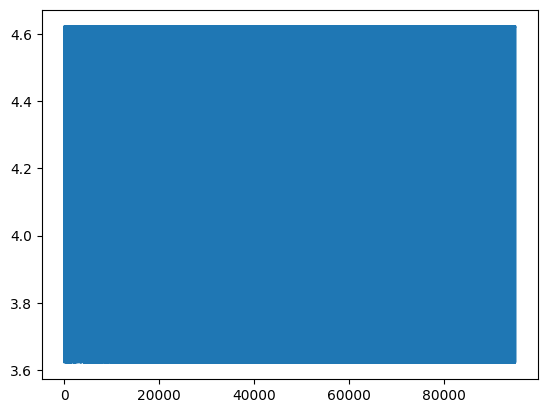

epoch : 18 , acc :  0.092


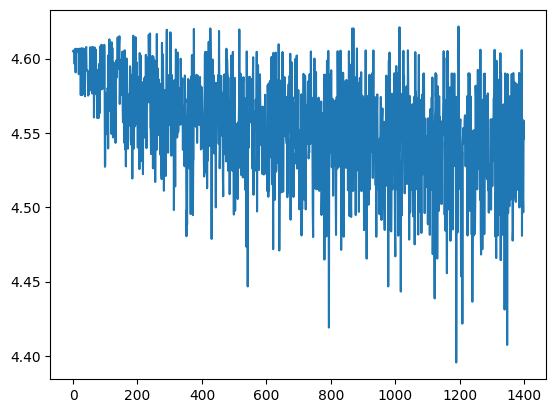

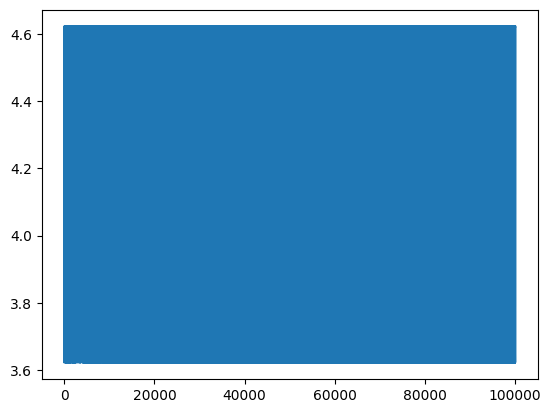

epoch : 19 , acc :  0.0898


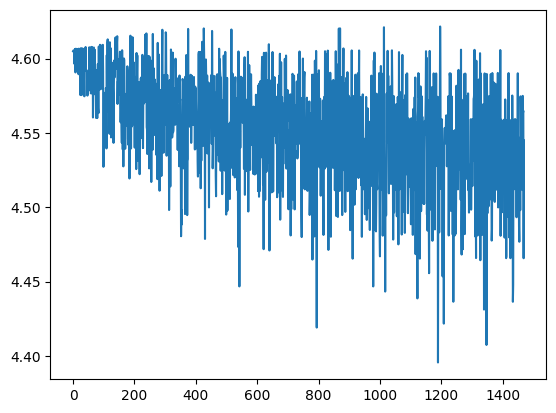

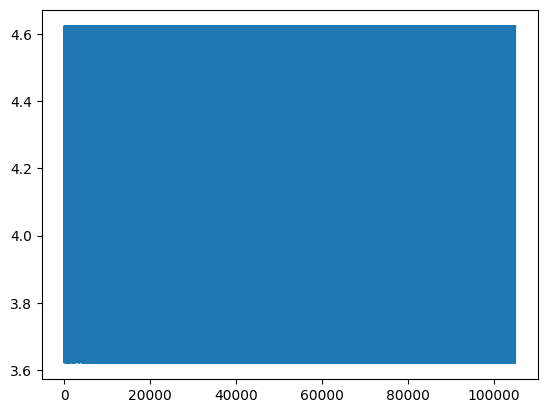

epoch : 20 , acc :  0.0948


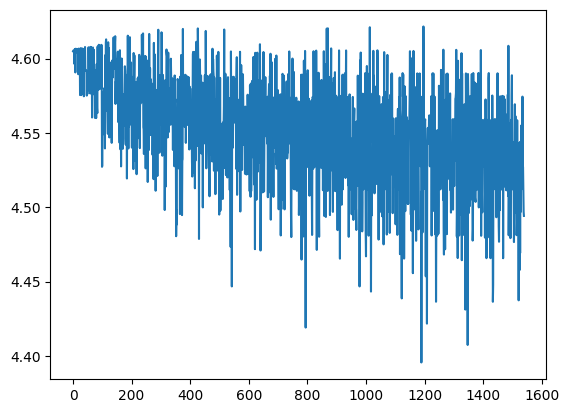

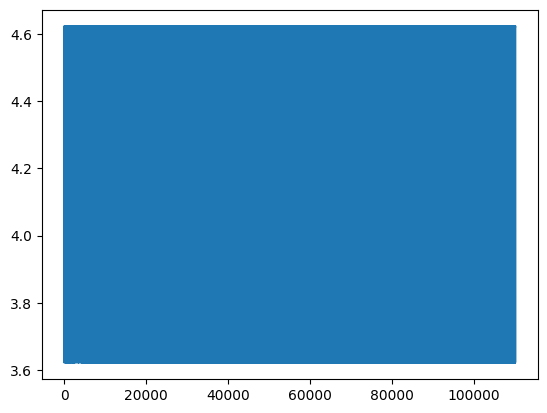

epoch : 21 , acc :  0.0914


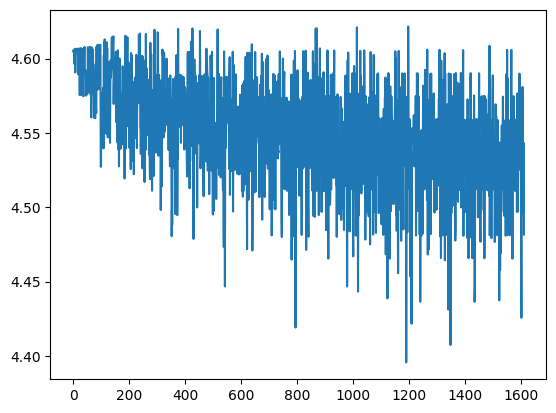

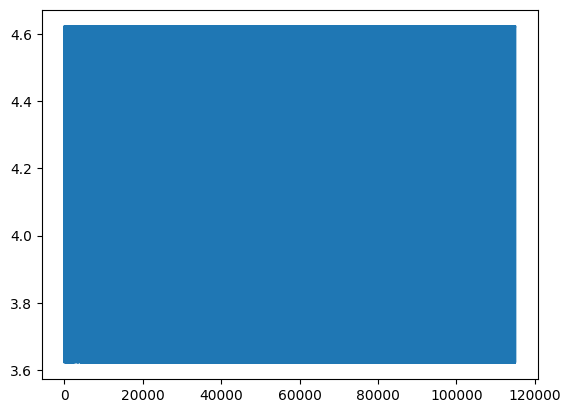

epoch : 22 , acc :  0.0888


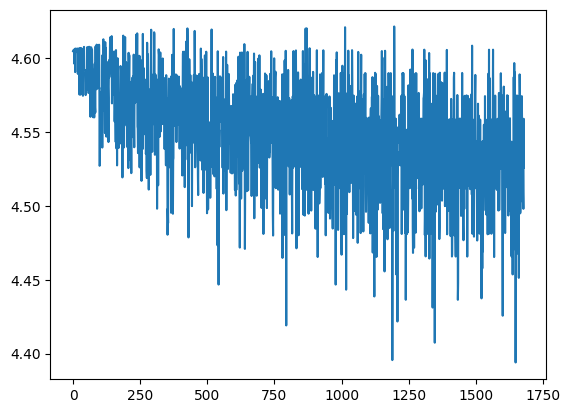

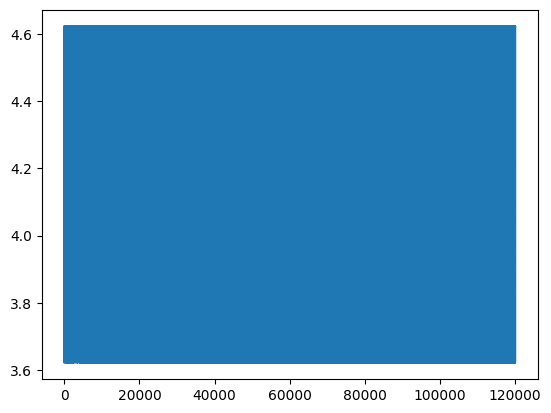

epoch : 23 , acc :  0.089


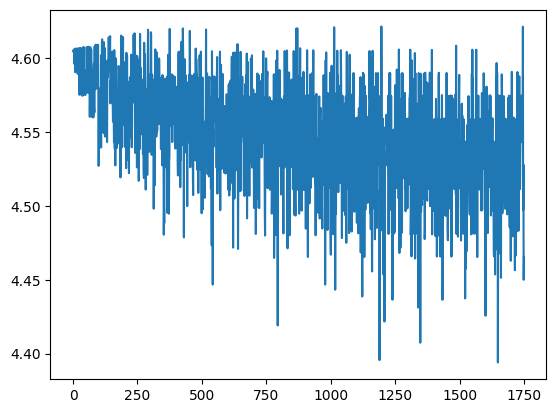

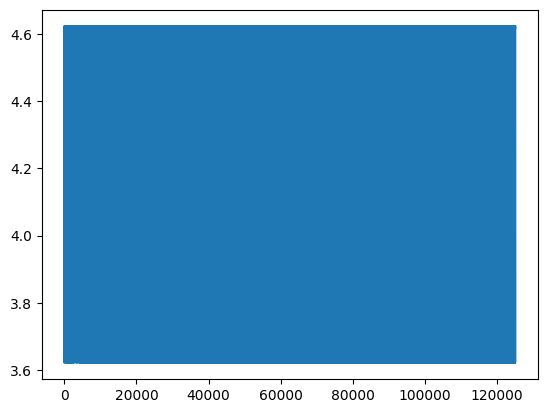

epoch : 24 , acc :  0.0884


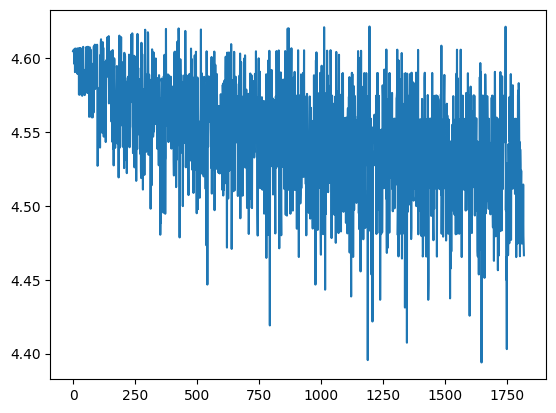

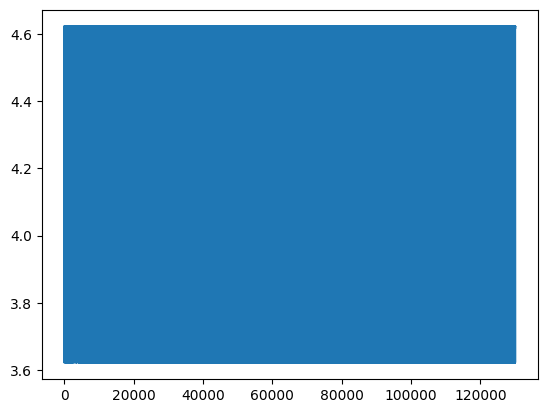

epoch : 25 , acc :  0.0942


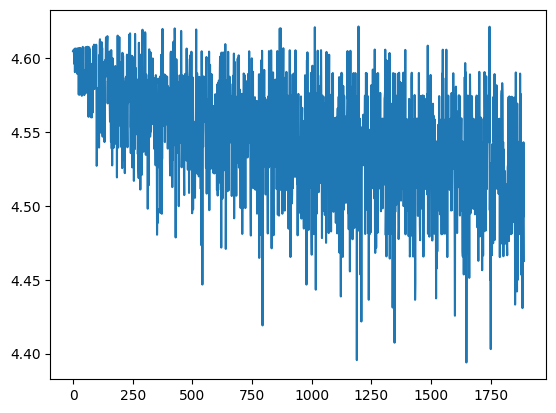

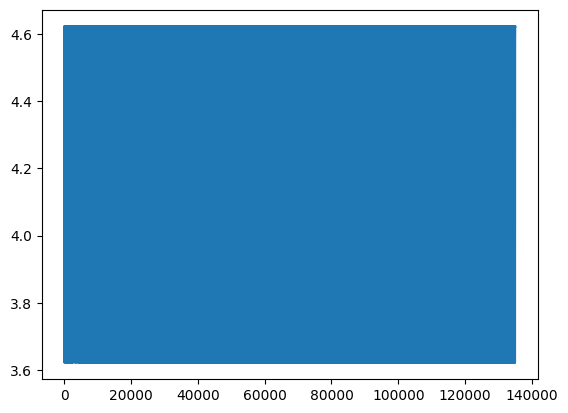

epoch : 26 , acc :  0.0878


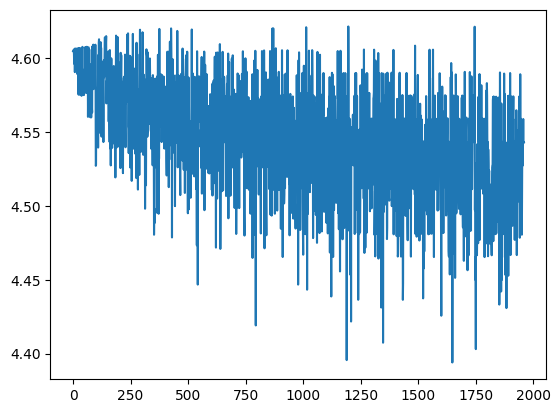

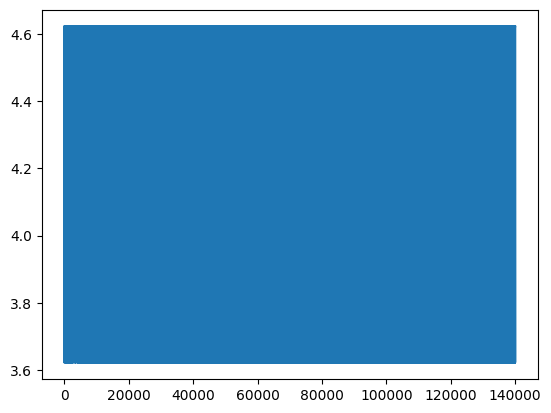

epoch : 27 , acc :  0.0928


KeyboardInterrupt: 

In [ ]:
tlosses = []
vlosses = []
for epoch in range(35):
    model.train()
    i=0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        inputs = inputs.float().to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # loss변화 확인용
        i+=1
        if not(i%10):
          tlosses.append(loss)



    correct, all_data = 0,0

    pLoss = torch.tensor(tlosses).cpu()
    plt.plot(pLoss)
    plt.show()
#

    model.eval()
    for data in val_loader:
        with torch.no_grad():
            inputs, labels, _ = data
            inputs = inputs.float().to(device)
            labels = labels.to(device)

            output = model(inputs)

            correct += torch.sum(torch.argmax(output, dim=1) == labels).item()
            all_data += len(labels)


            vlosses.append(criterion(output, labels))

    vLoss = torch.tensor(vlosses).cpu()
    plt.plot(vLoss)
    plt.show()
    print("epoch :", epoch,", acc : ", correct / all_data)



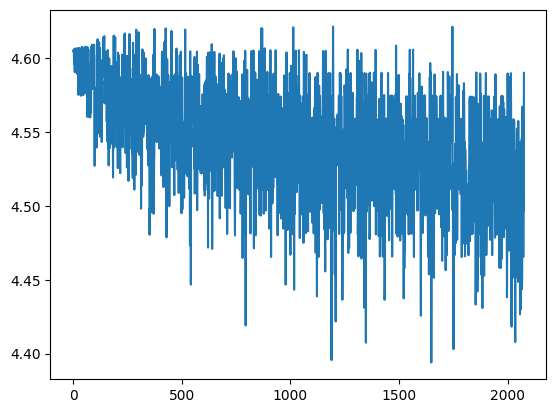

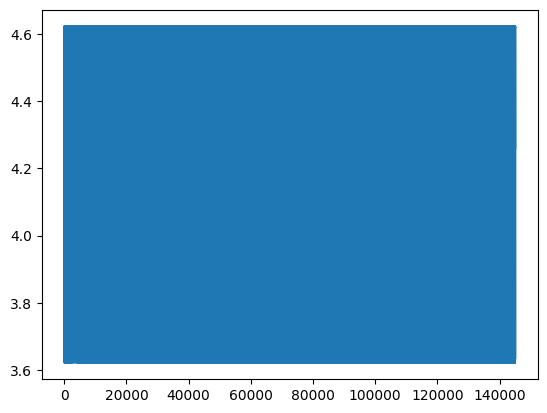

epoch : 0 , acc :  0.1036


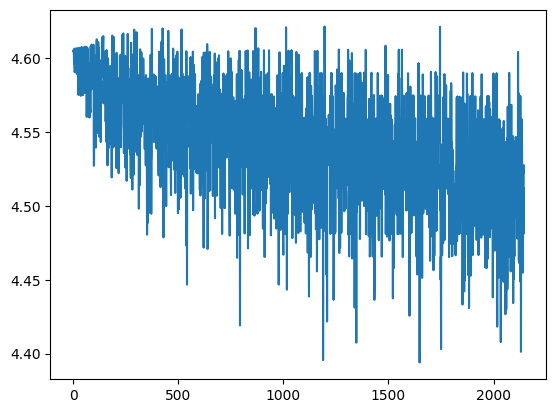

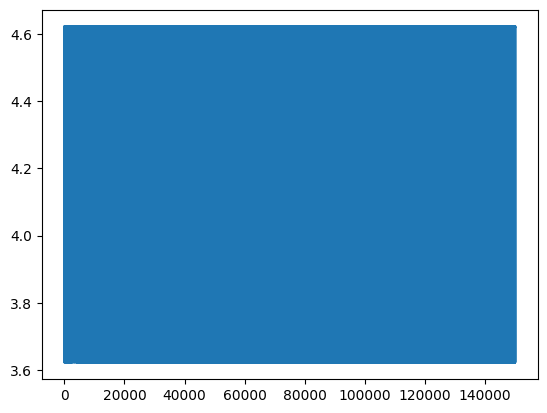

epoch : 1 , acc :  0.1028


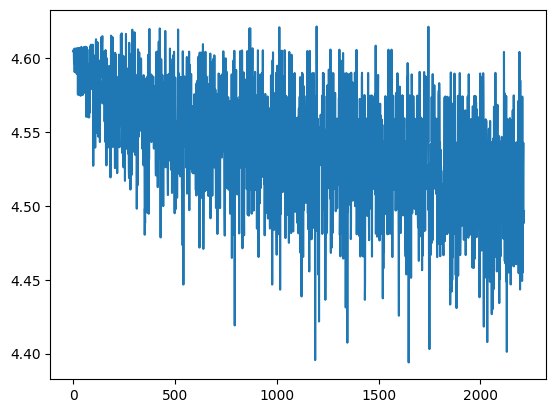

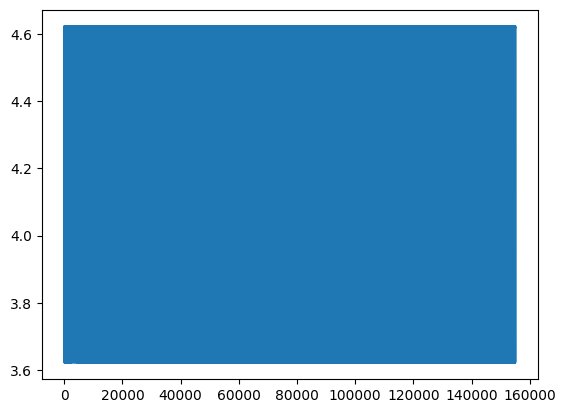

epoch : 2 , acc :  0.1046


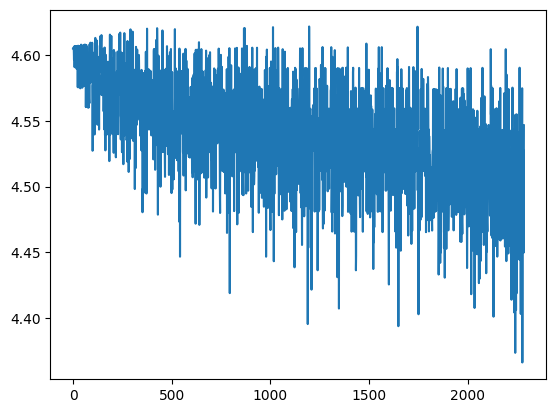

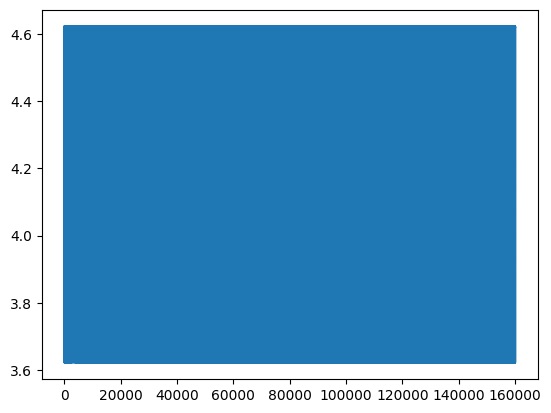

epoch : 3 , acc :  0.1064


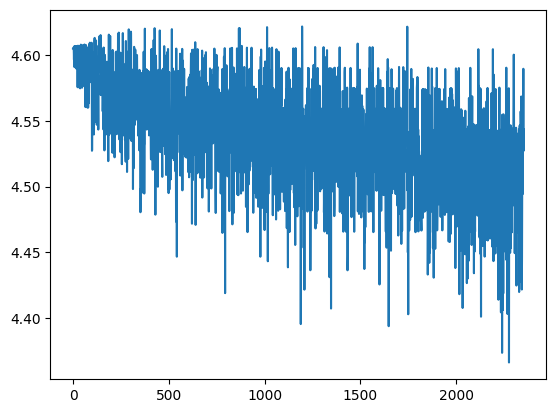

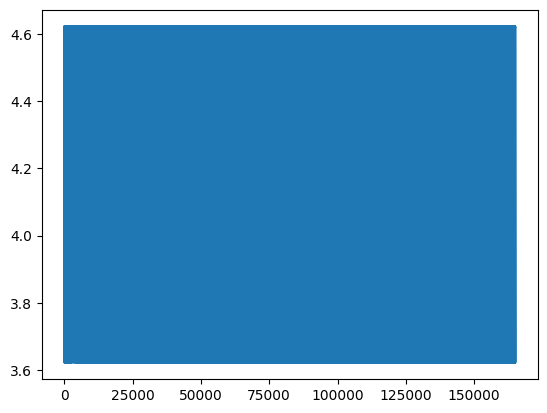

epoch : 4 , acc :  0.1064


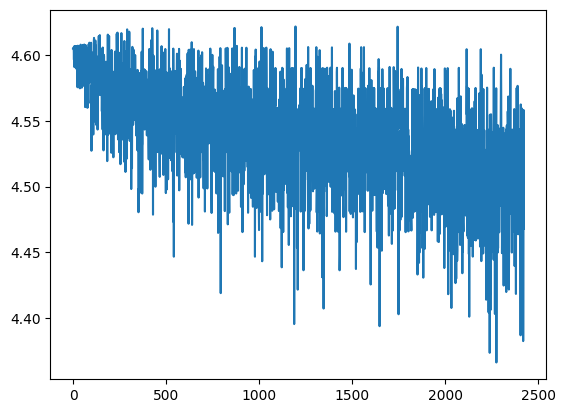

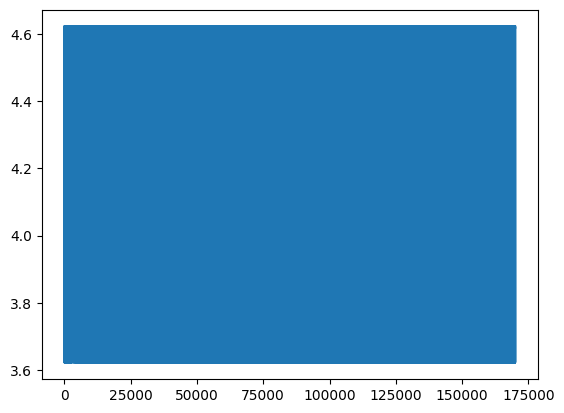

epoch : 5 , acc :  0.1036


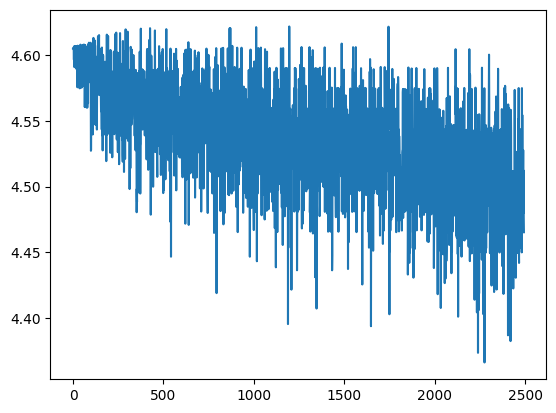

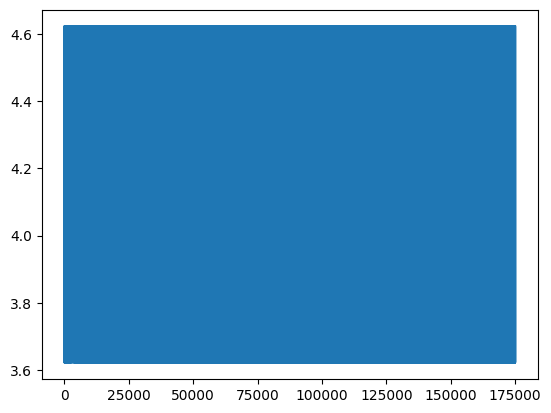

epoch : 6 , acc :  0.1076


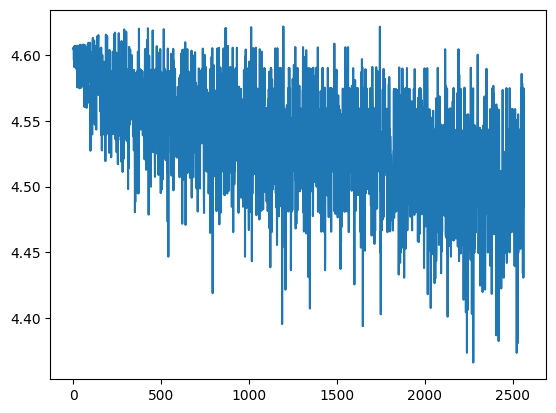

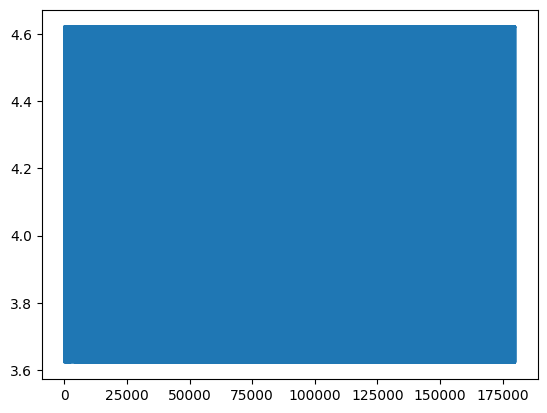

epoch : 7 , acc :  0.1108


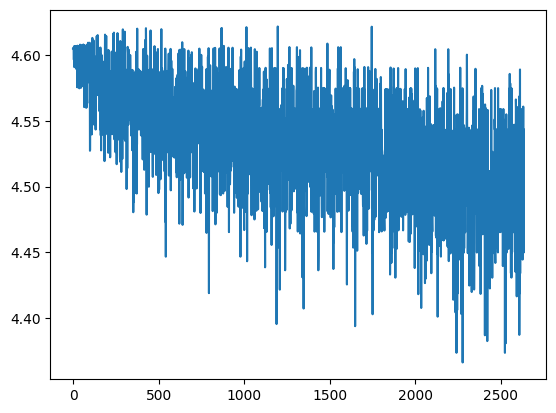

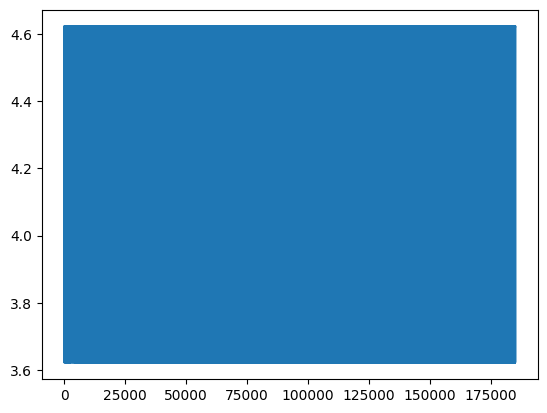

epoch : 8 , acc :  0.11


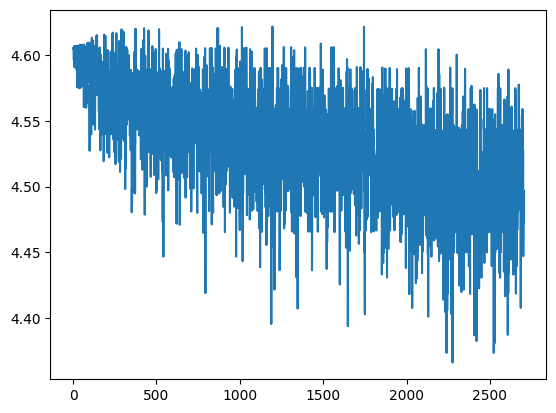

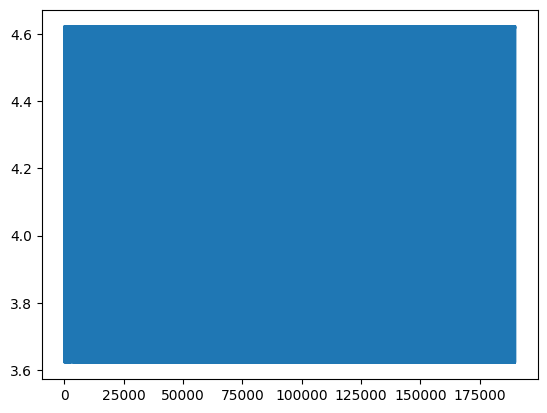

epoch : 9 , acc :  0.1086


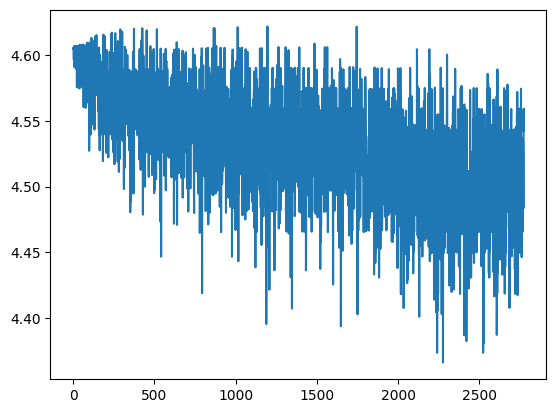

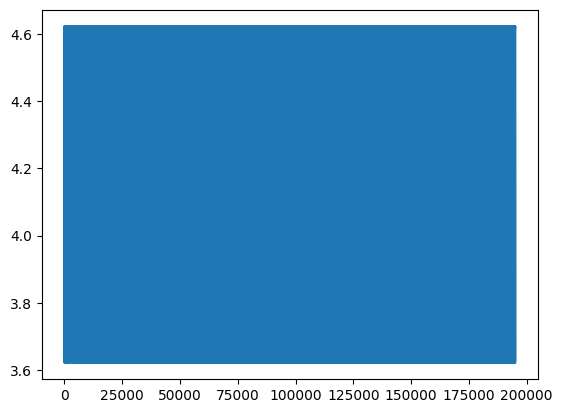

epoch : 10 , acc :  0.1128


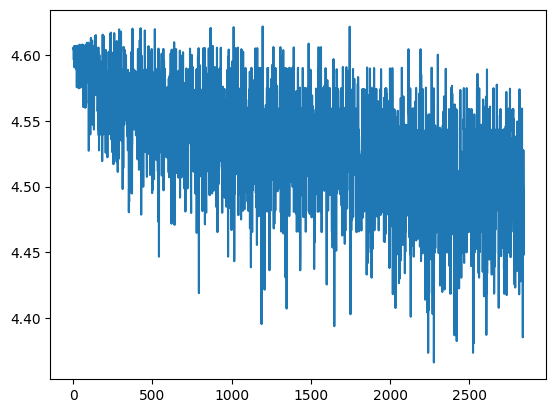

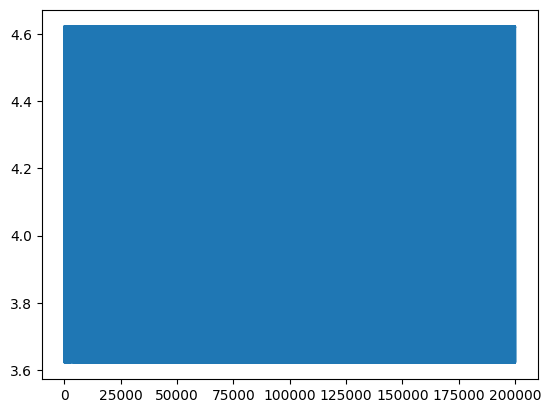

epoch : 11 , acc :  0.1098


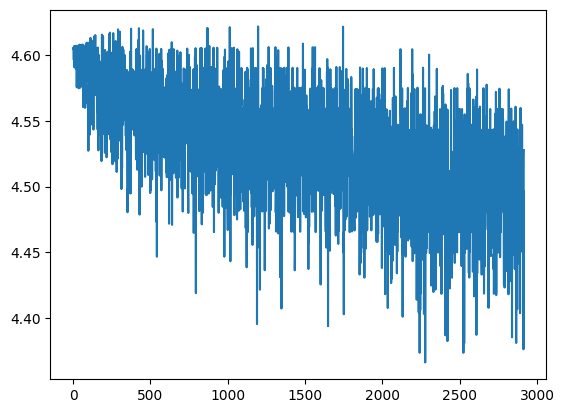

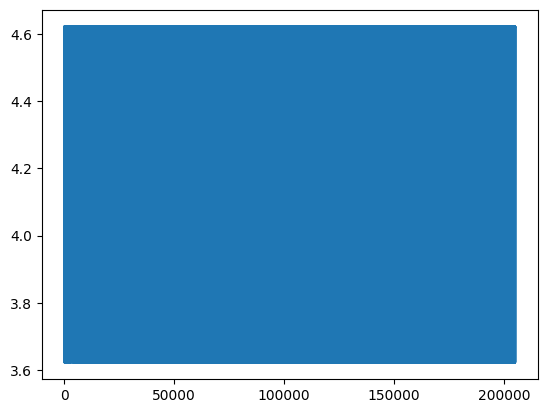

epoch : 12 , acc :  0.1098


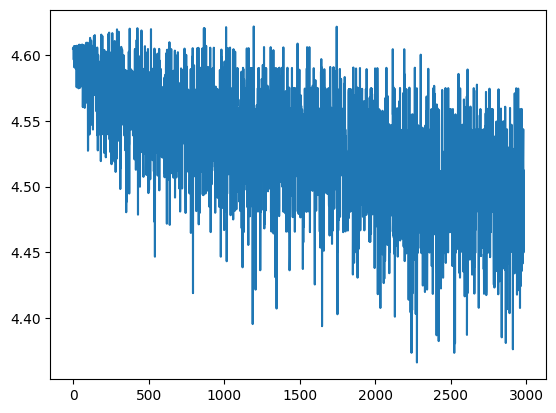

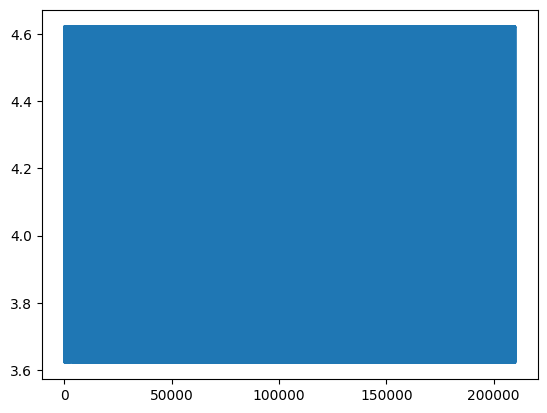

epoch : 13 , acc :  0.1106


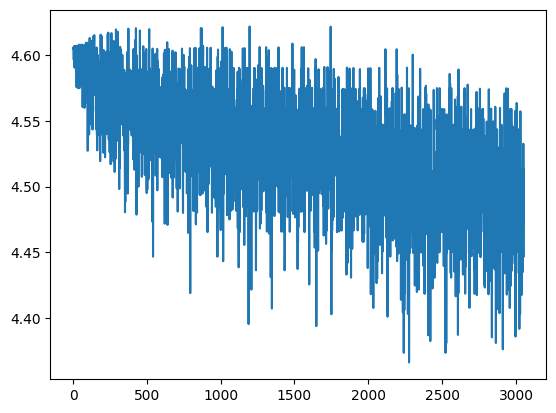

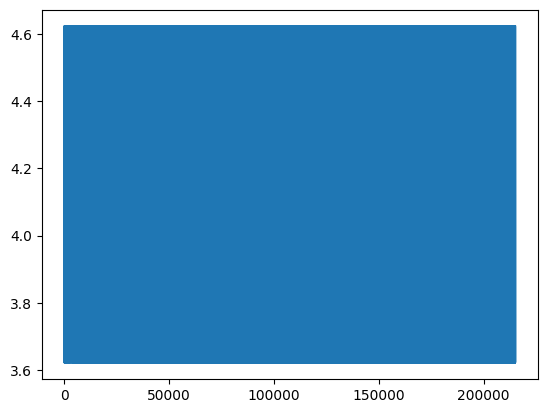

epoch : 14 , acc :  0.1104


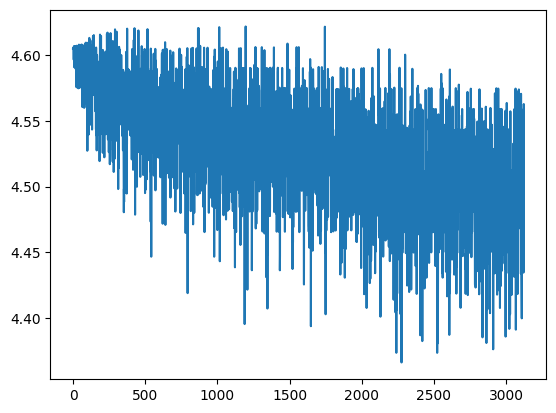

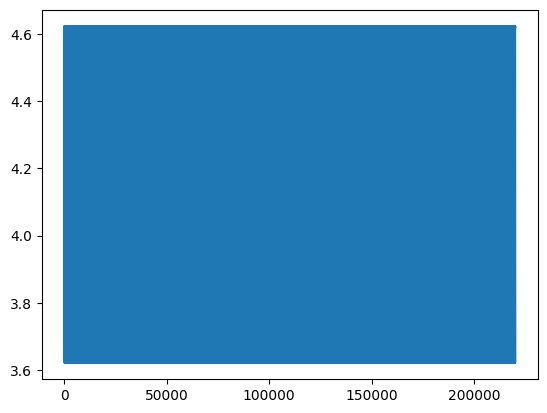

epoch : 15 , acc :  0.1114


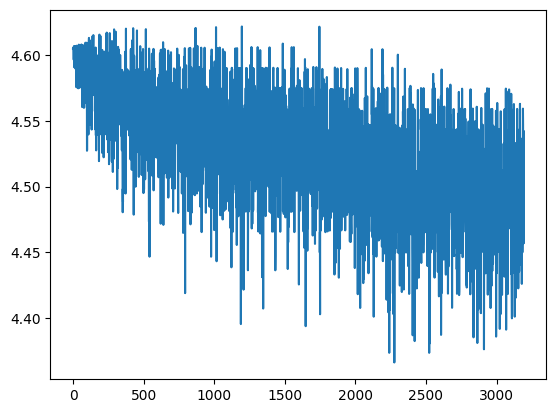

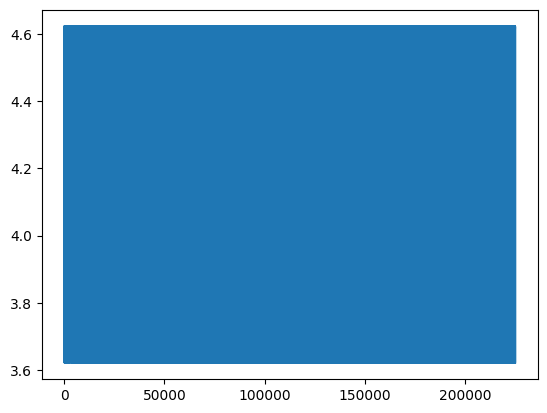

epoch : 16 , acc :  0.1086


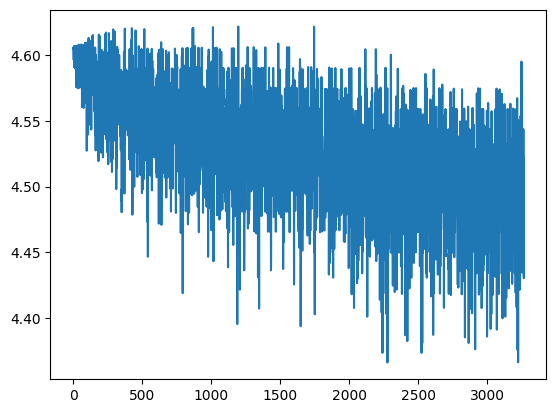

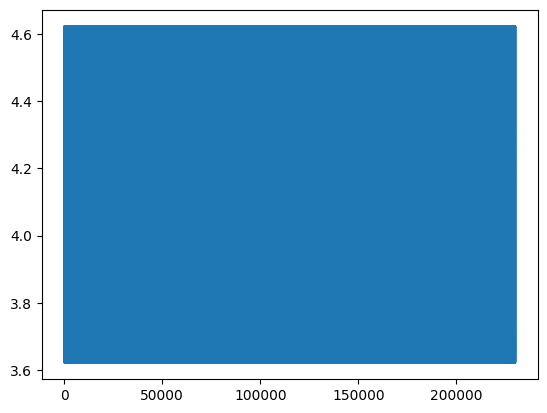

epoch : 17 , acc :  0.1042


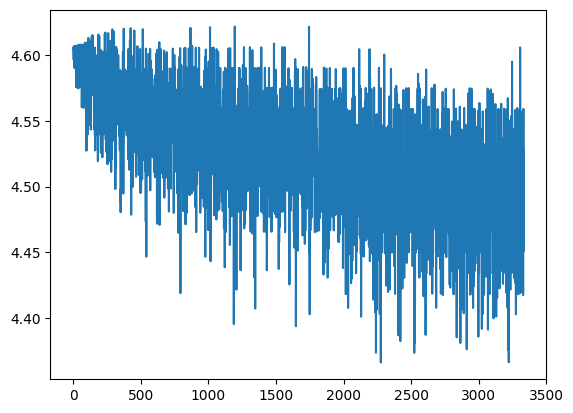

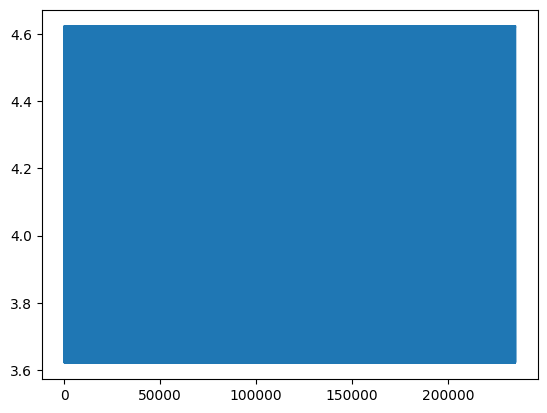

epoch : 18 , acc :  0.11


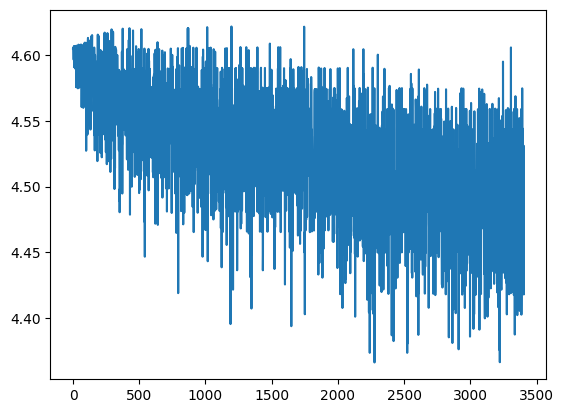

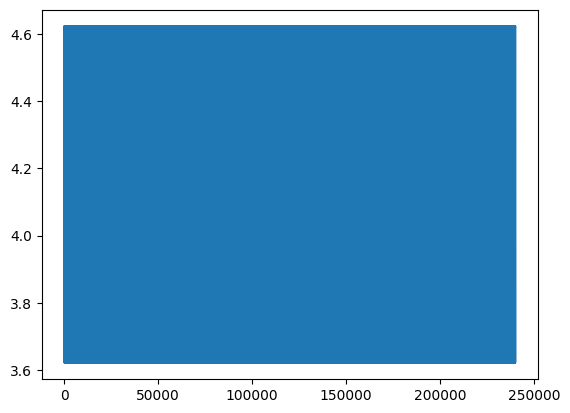

epoch : 19 , acc :  0.114


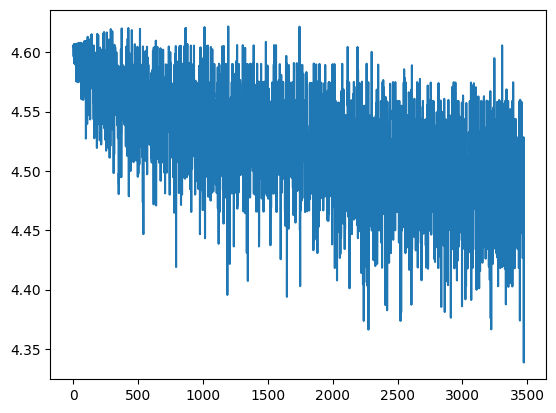

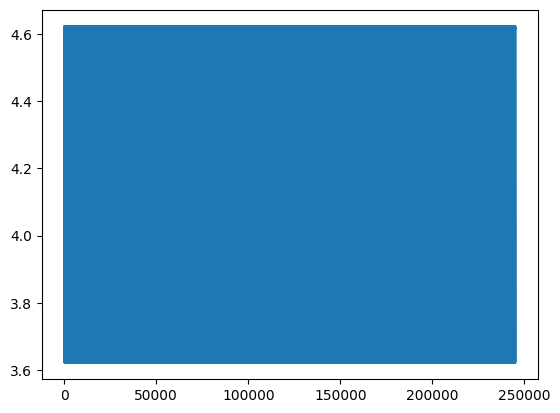

epoch : 20 , acc :  0.1108


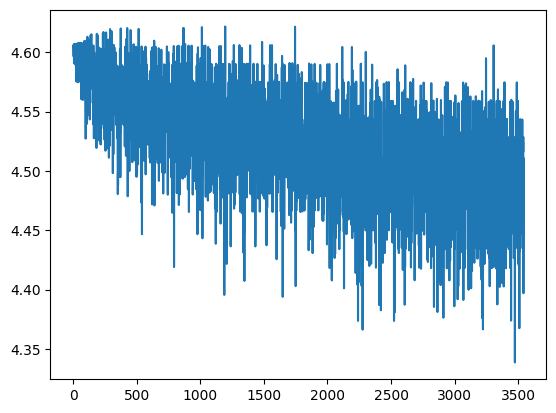

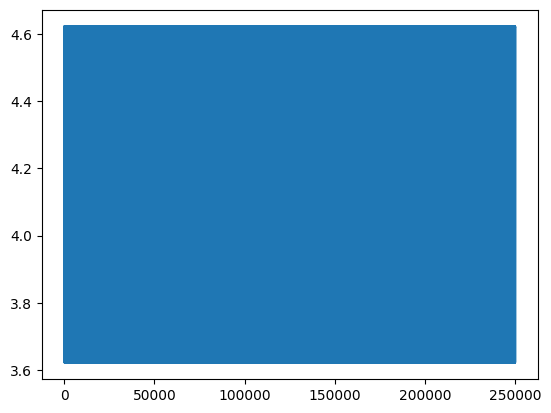

epoch : 21 , acc :  0.1152


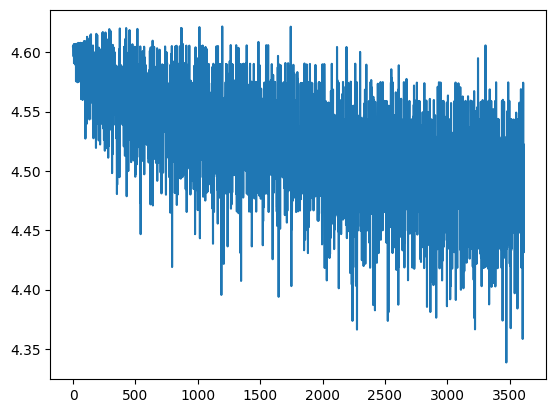

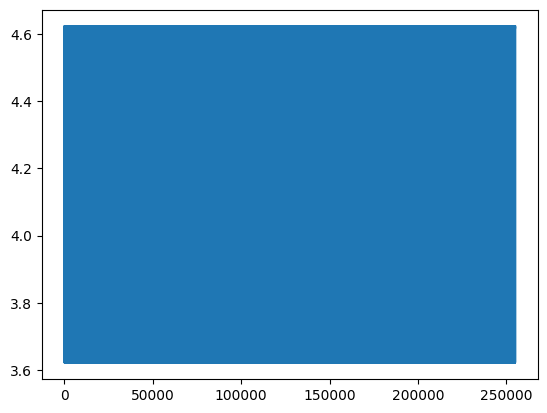

epoch : 22 , acc :  0.1172


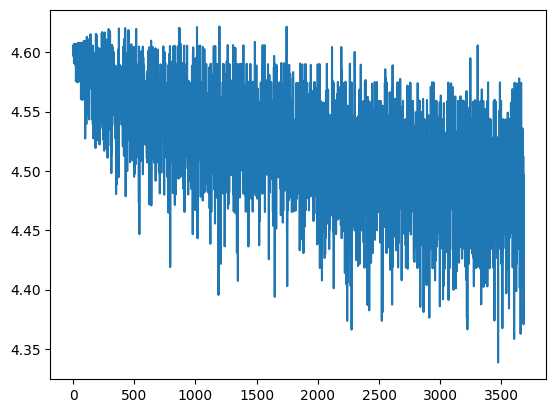

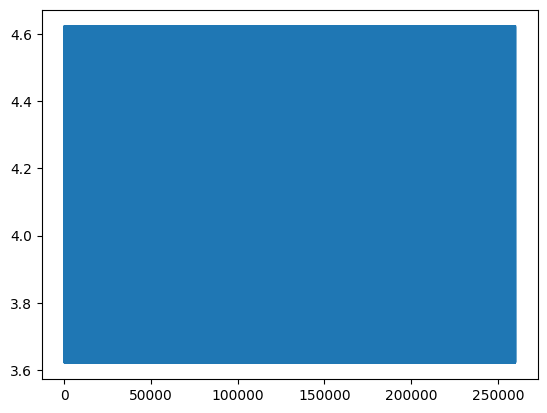

epoch : 23 , acc :  0.1106


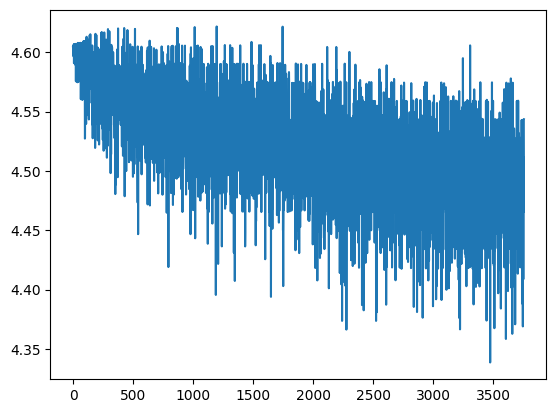

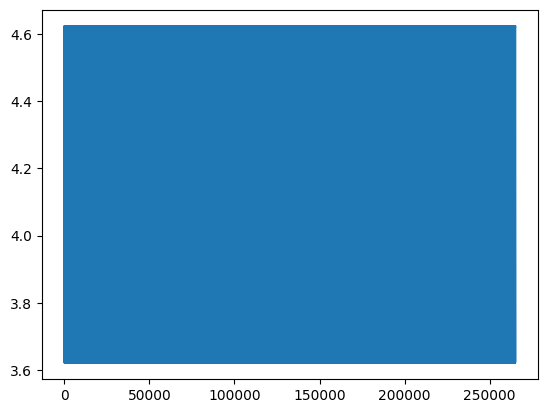

epoch : 24 , acc :  0.1158


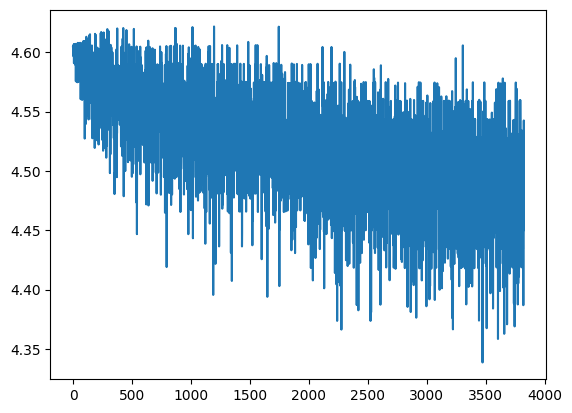

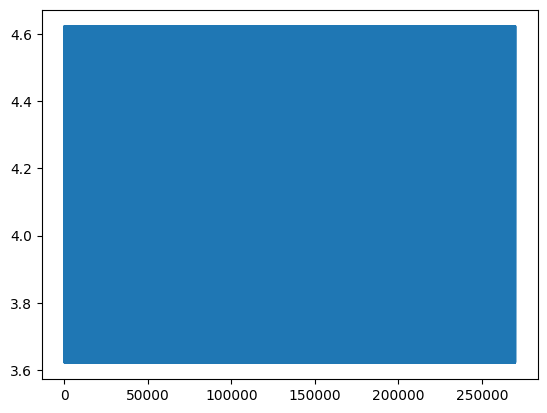

epoch : 25 , acc :  0.1096


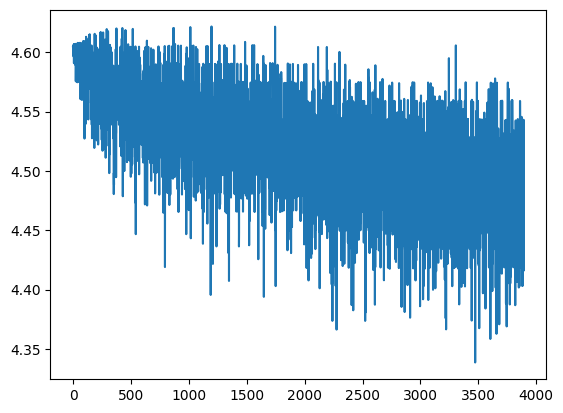

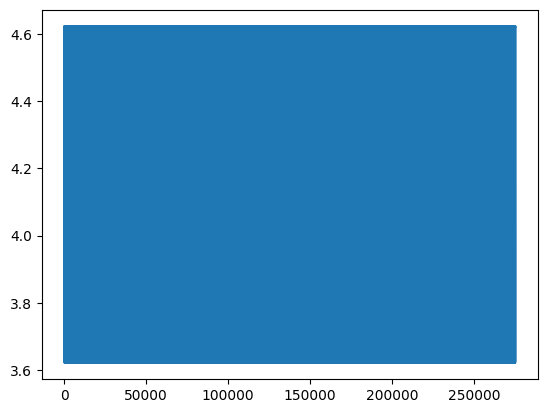

epoch : 26 , acc :  0.1146


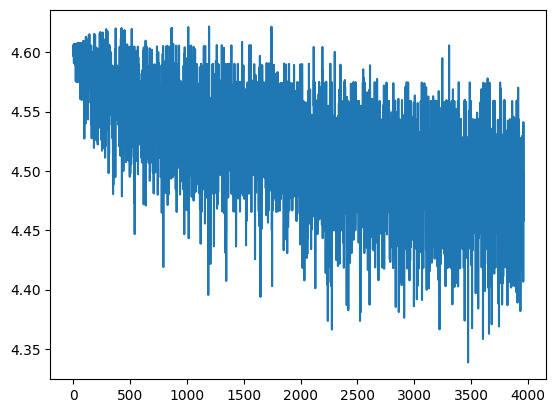

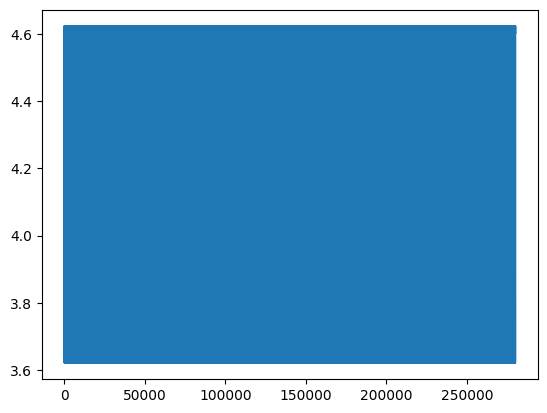

epoch : 27 , acc :  0.1152


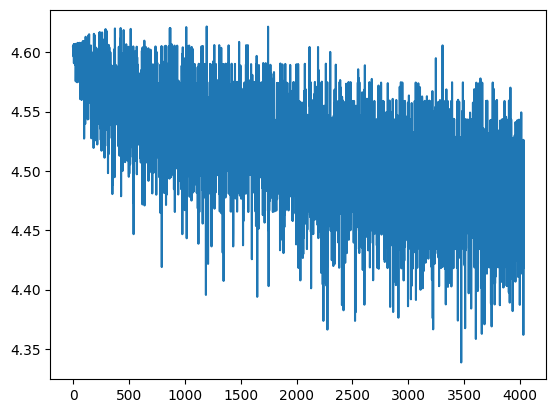

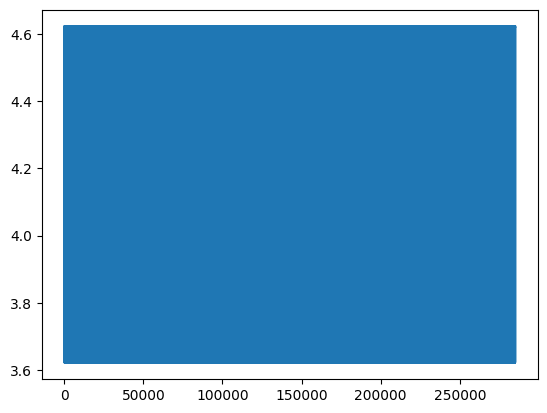

epoch : 28 , acc :  0.1142


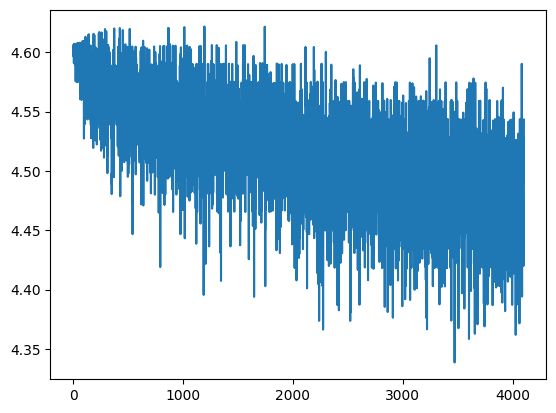

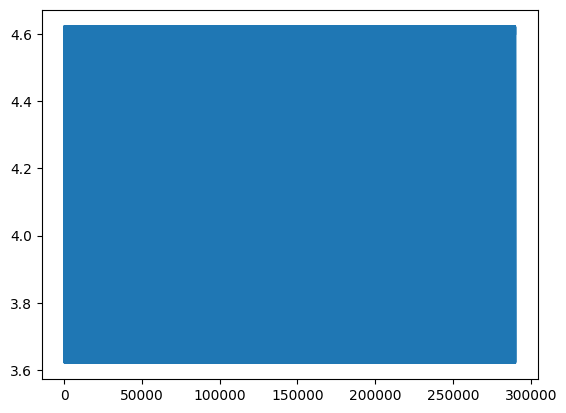

epoch : 29 , acc :  0.1138


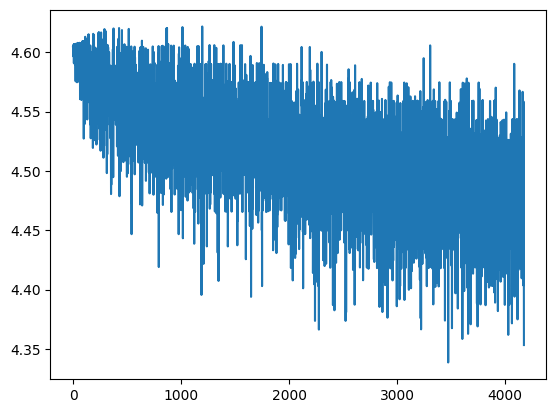

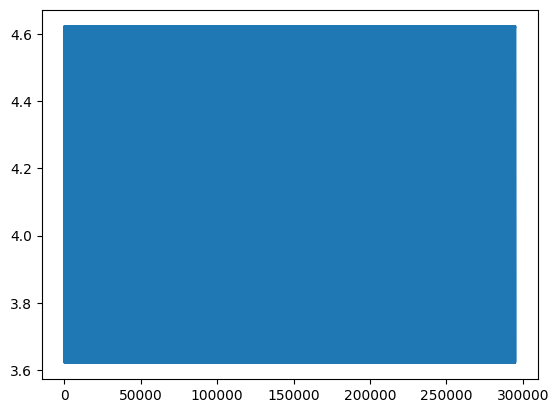

epoch : 30 , acc :  0.1182


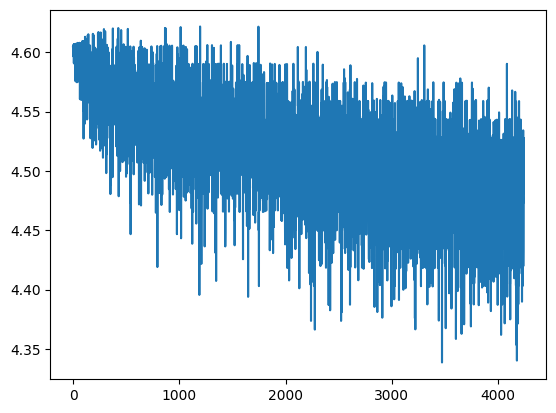

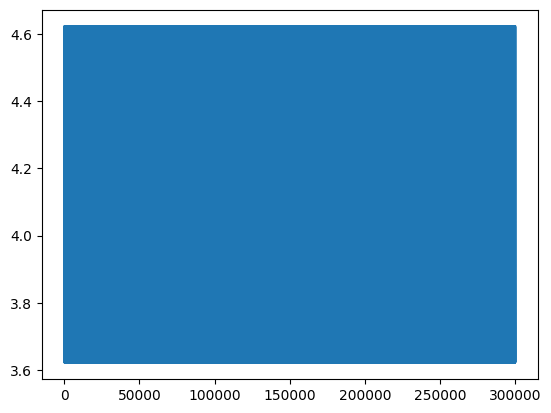

epoch : 31 , acc :  0.117


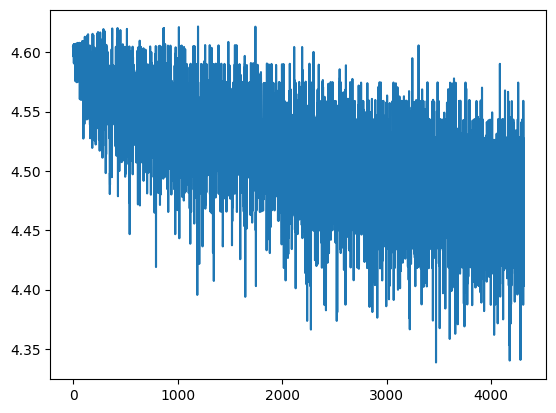

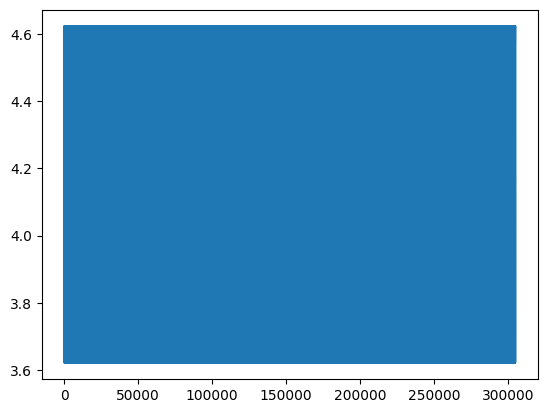

epoch : 32 , acc :  0.1162


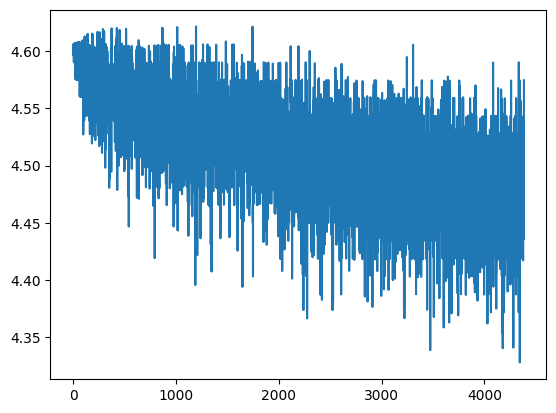

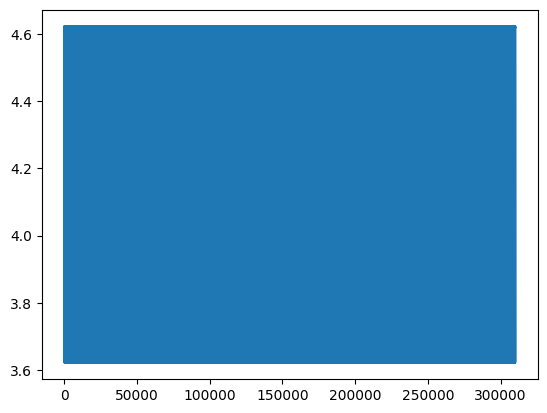

epoch : 33 , acc :  0.1172


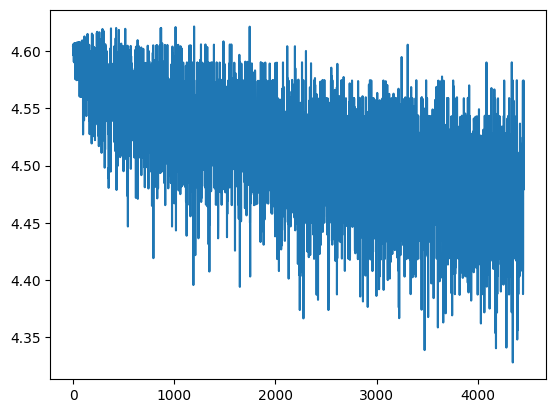

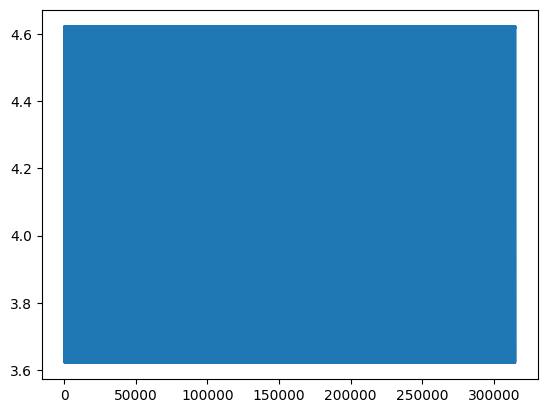

epoch : 34 , acc :  0.1168


In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.1)

for epoch in range(35):
    model.train()
    i=0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        inputs = inputs.float().to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # loss변화 확인용
        i+=1
        if not(i%10):
          tlosses.append(loss)



    correct, all_data = 0,0

    pLoss = torch.tensor(tlosses).cpu()
    plt.plot(pLoss)
    plt.show()
#

    model.eval()
    for data in val_loader:
        with torch.no_grad():
            inputs, labels, _ = data
            inputs = inputs.float().to(device)
            labels = labels.to(device)

            output = model(inputs)

            correct += torch.sum(torch.argmax(output, dim=1) == labels).item()
            all_data += len(labels)


            vlosses.append(criterion(output, labels))

    vLoss = torch.tensor(vlosses).cpu()
    plt.plot(vLoss)
    plt.show()
    print("epoch :", epoch,", acc : ", correct / all_data)



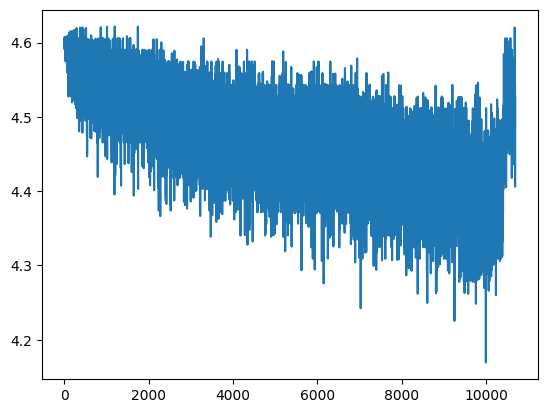

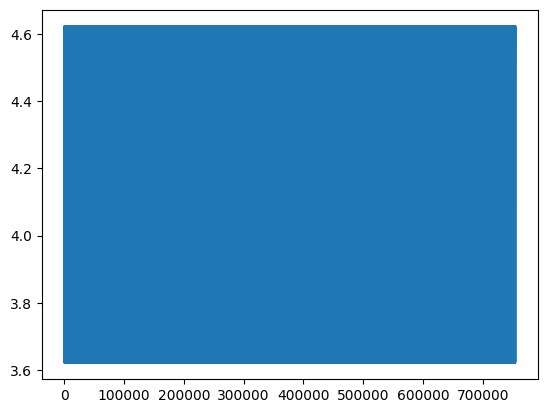

epoch : 0 , acc :  0.108


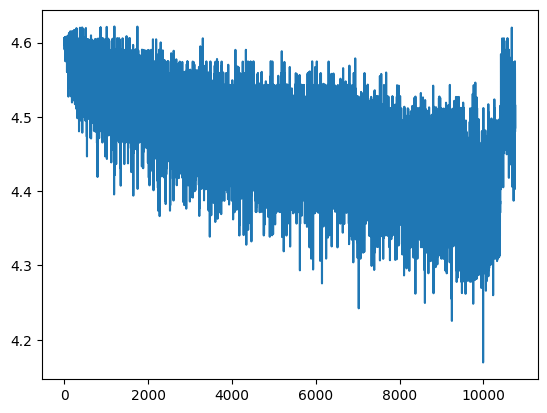

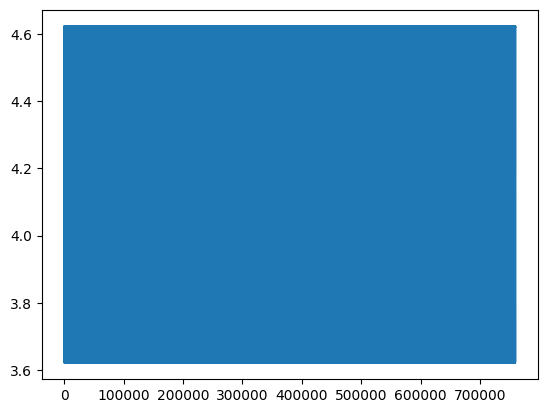

epoch : 1 , acc :  0.1136


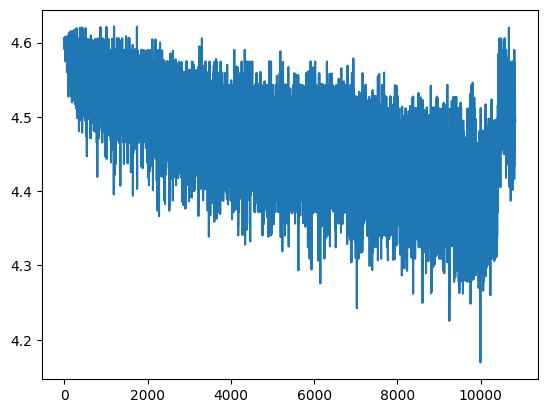

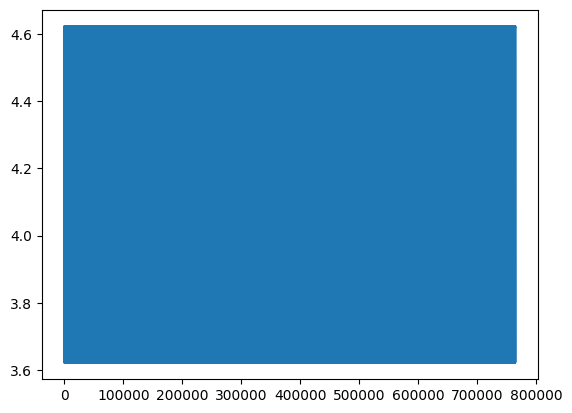

epoch : 2 , acc :  0.1184


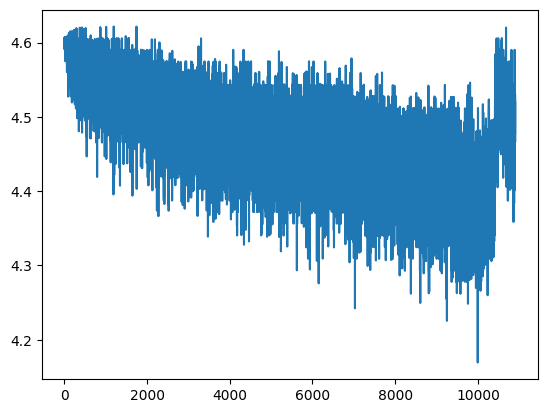

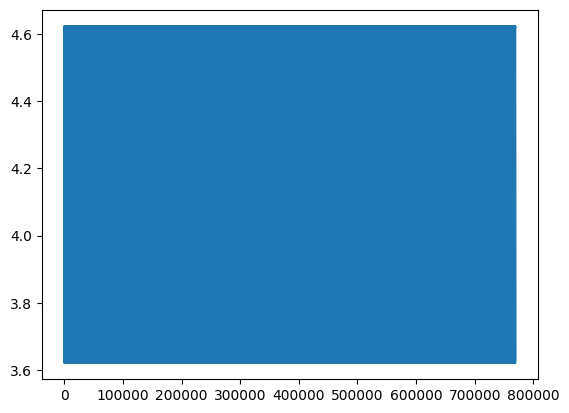

epoch : 3 , acc :  0.1224


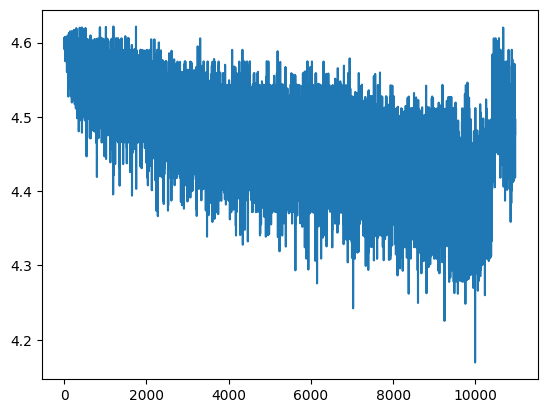

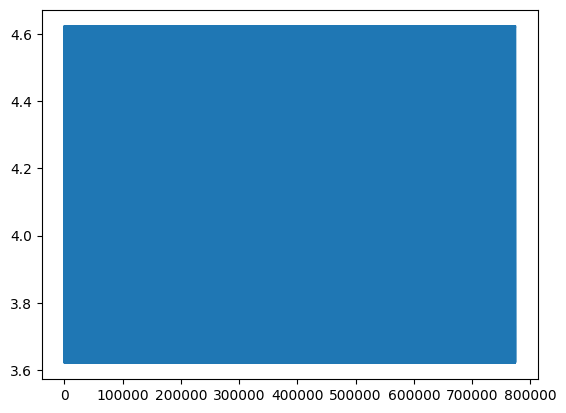

epoch : 4 , acc :  0.124


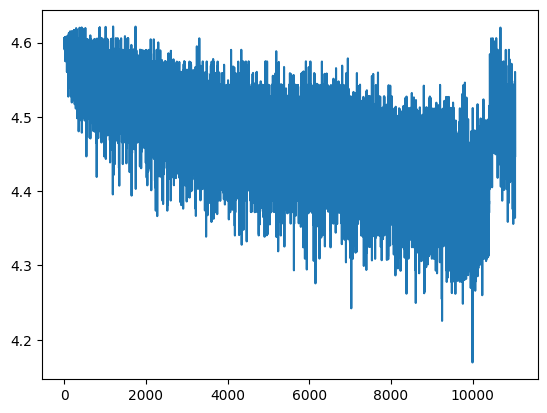

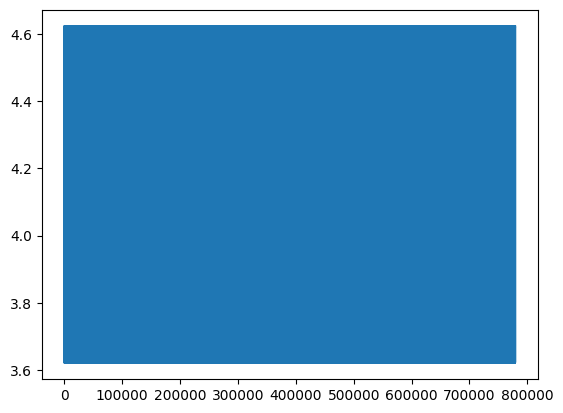

epoch : 5 , acc :  0.129


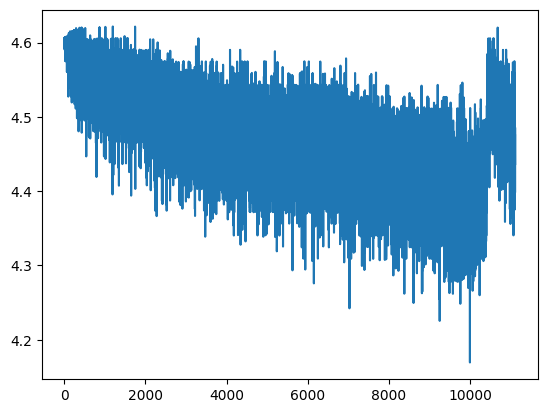

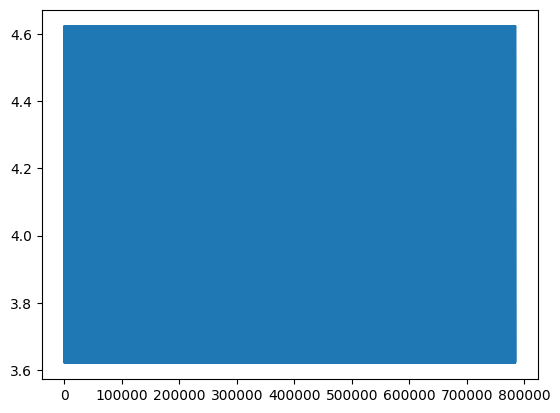

epoch : 6 , acc :  0.1286


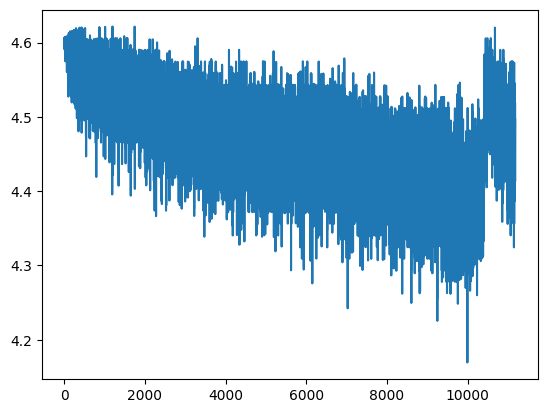

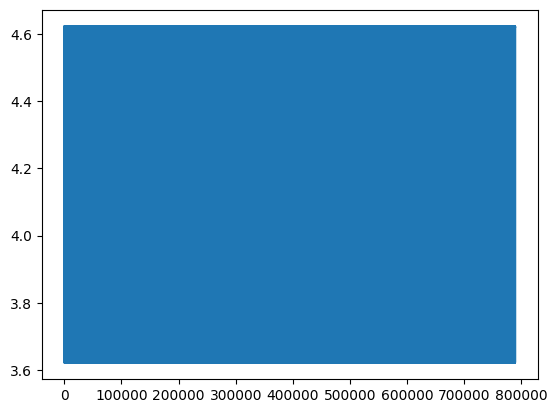

epoch : 7 , acc :  0.1298


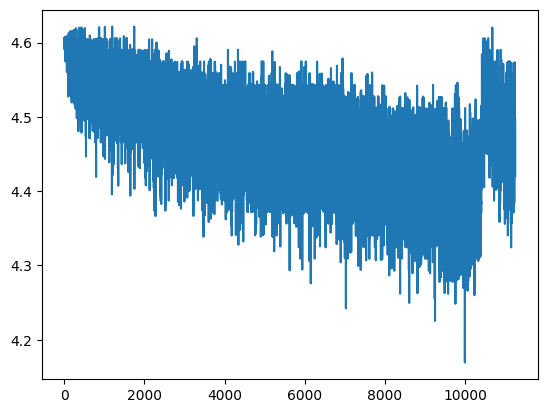

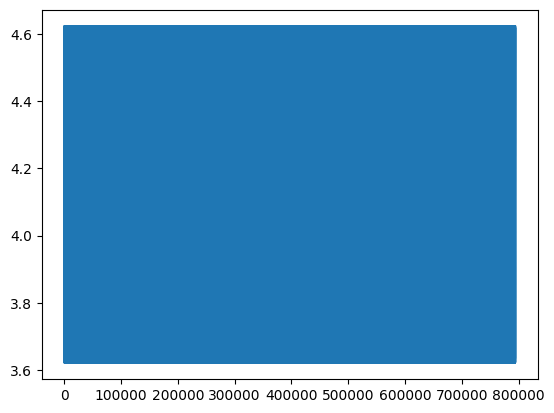

epoch : 8 , acc :  0.133


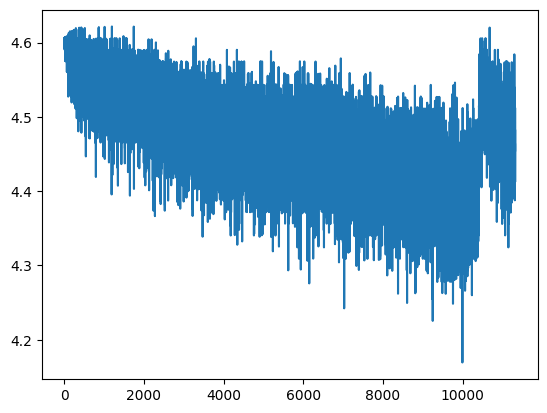

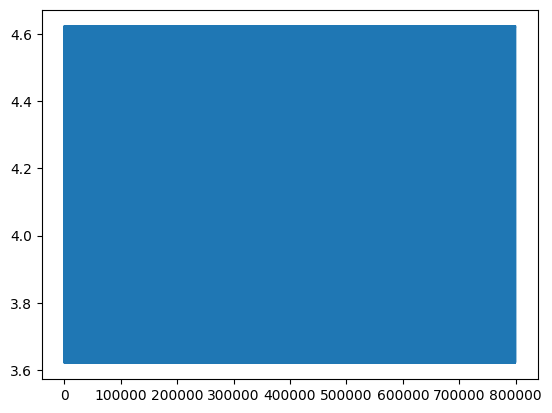

epoch : 9 , acc :  0.1342


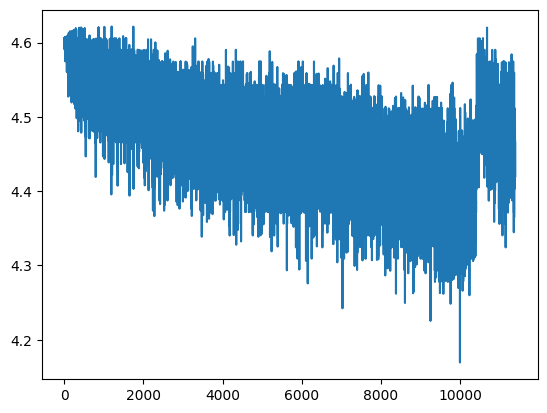

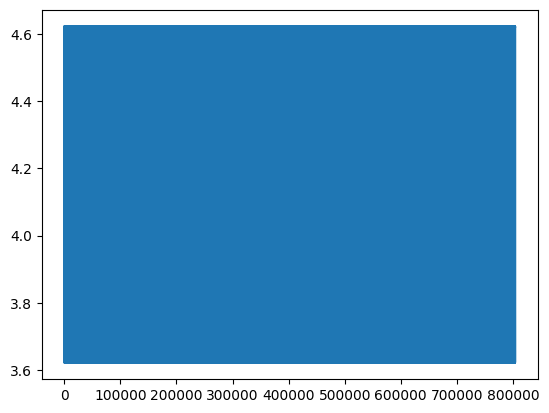

epoch : 10 , acc :  0.1356


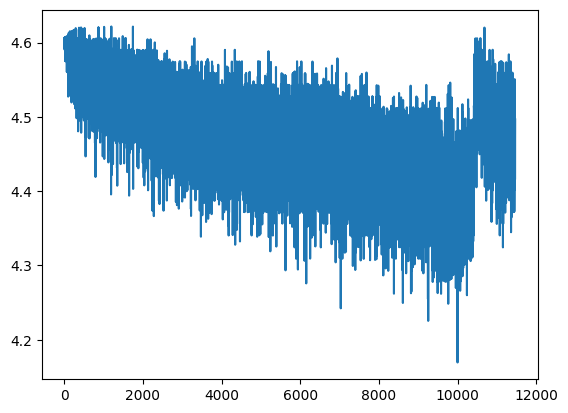

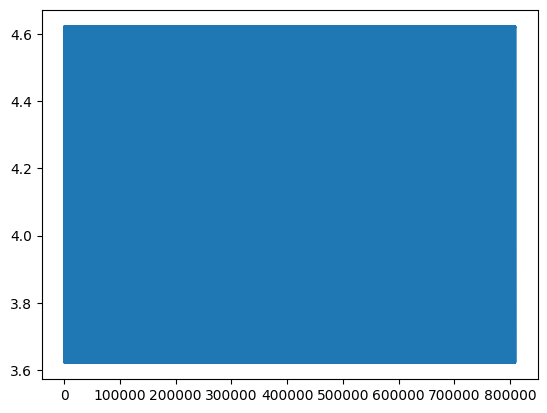

epoch : 11 , acc :  0.1344


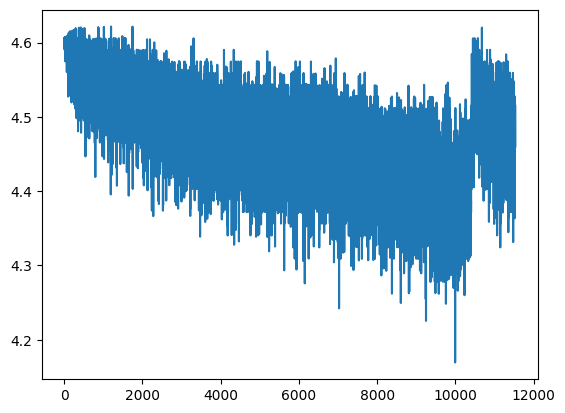

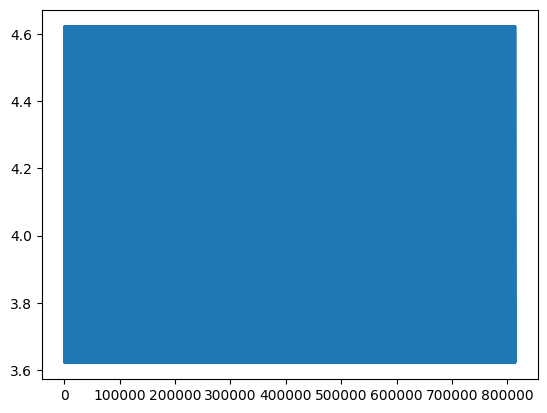

epoch : 12 , acc :  0.1342


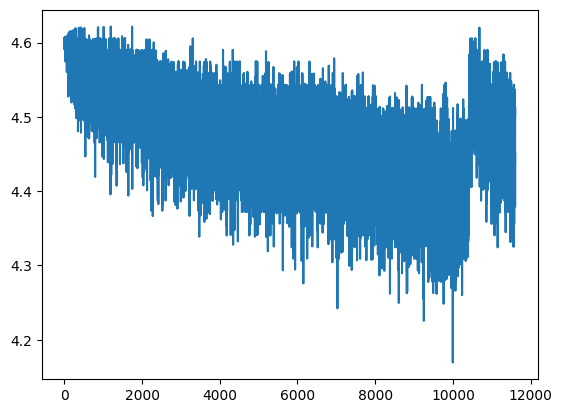

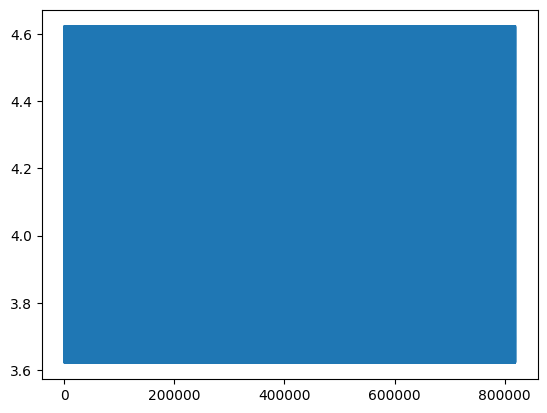

epoch : 13 , acc :  0.1368


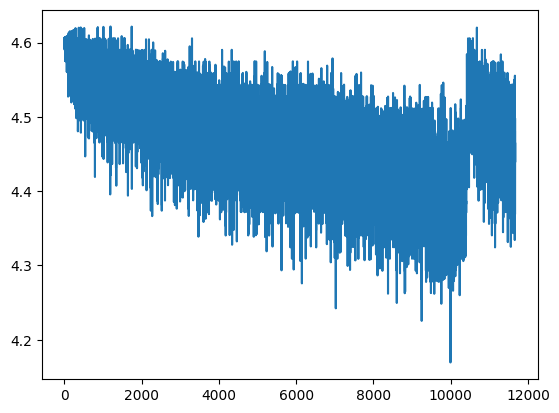

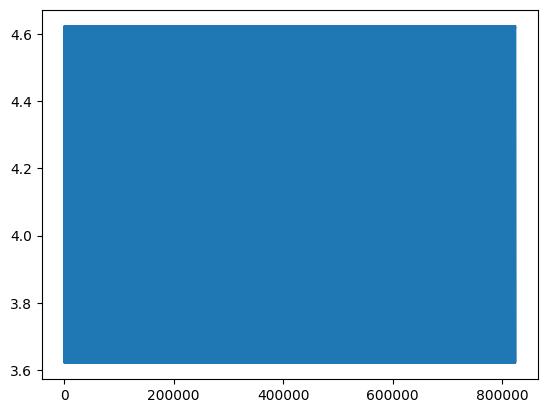

epoch : 14 , acc :  0.1378


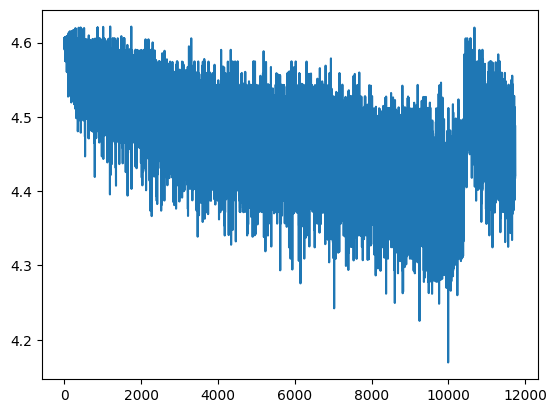

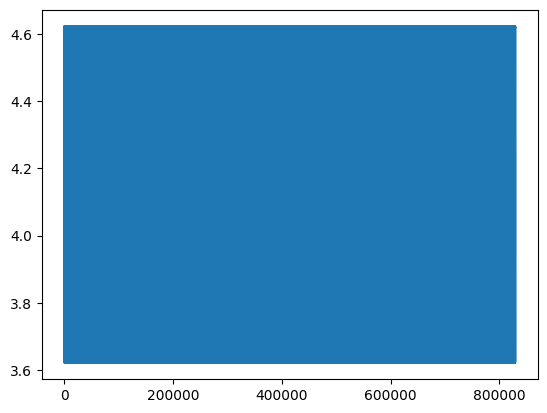

epoch : 15 , acc :  0.134


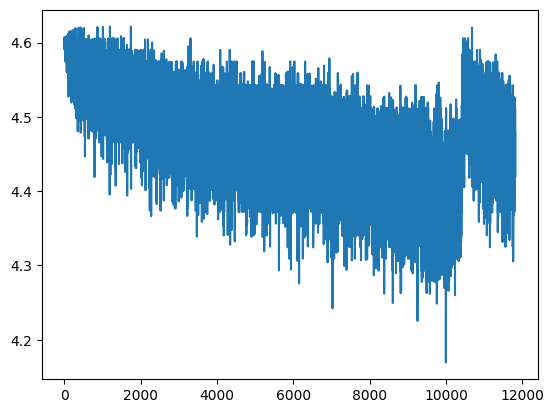

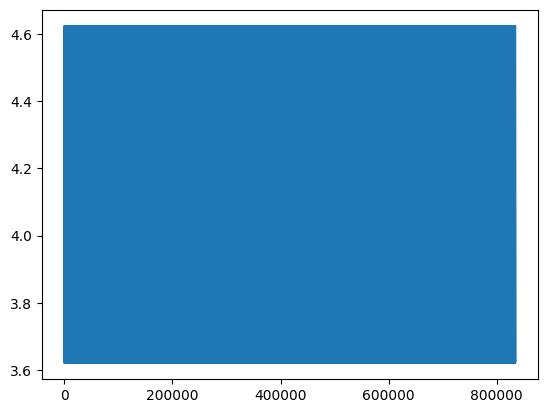

epoch : 16 , acc :  0.1334


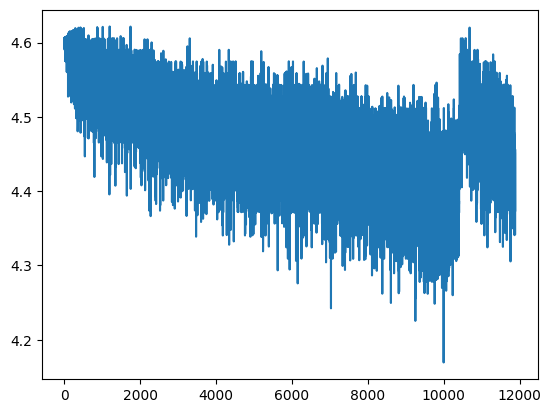

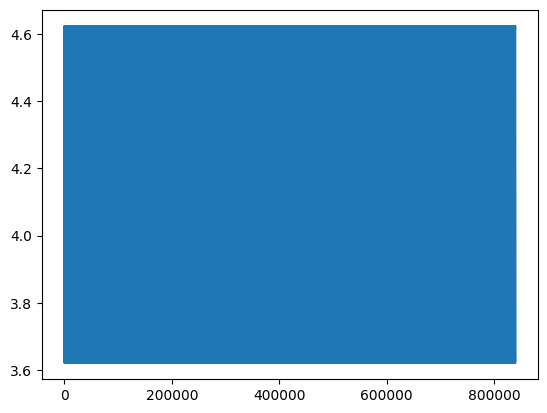

epoch : 17 , acc :  0.1378


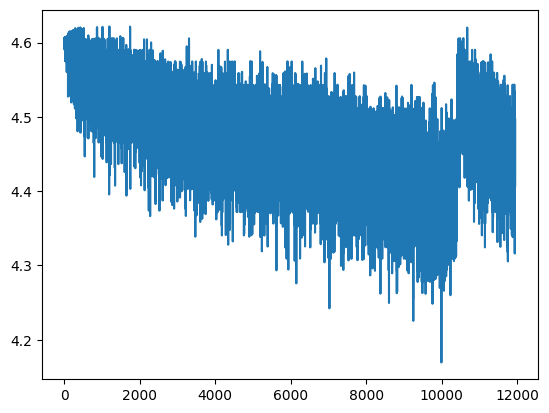

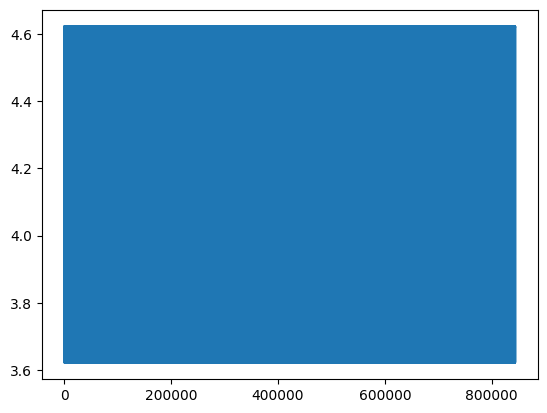

epoch : 18 , acc :  0.1388


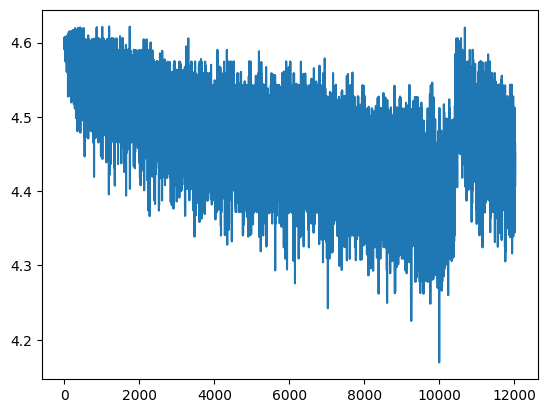

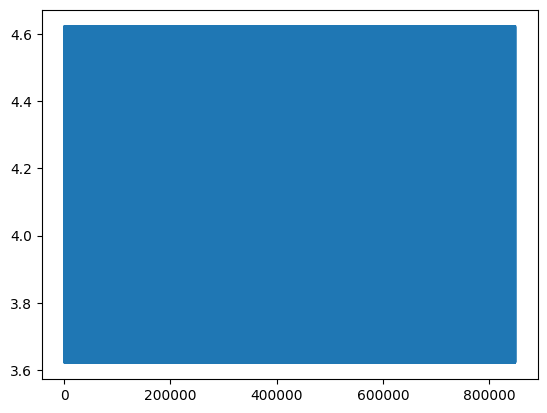

epoch : 19 , acc :  0.1396


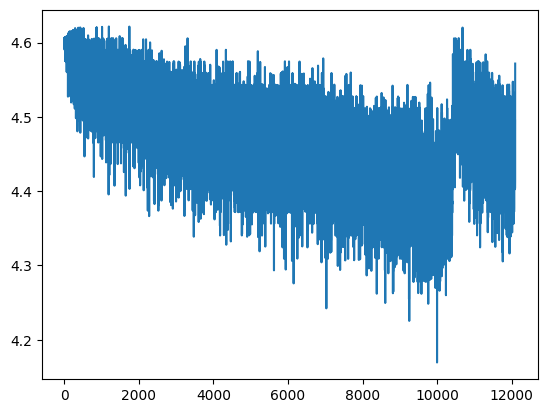

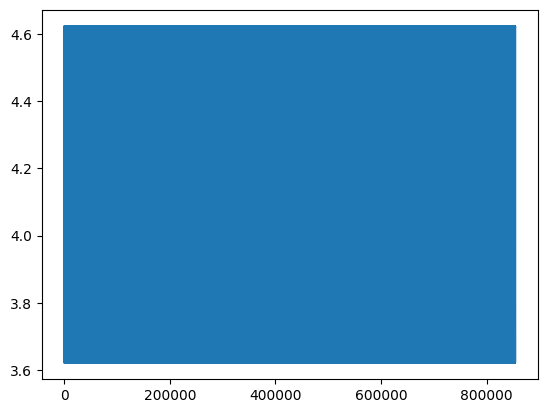

epoch : 20 , acc :  0.1386


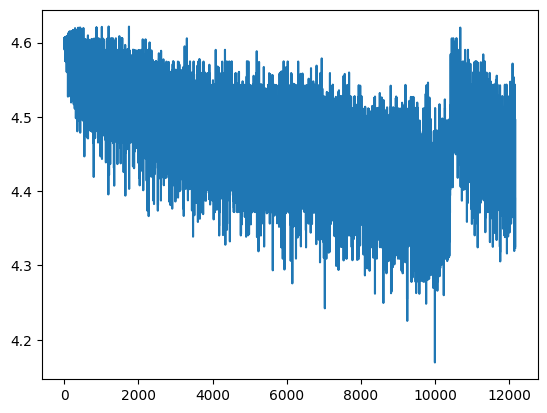

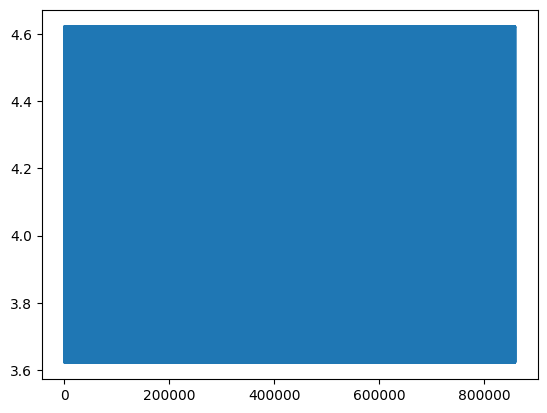

epoch : 21 , acc :  0.1404


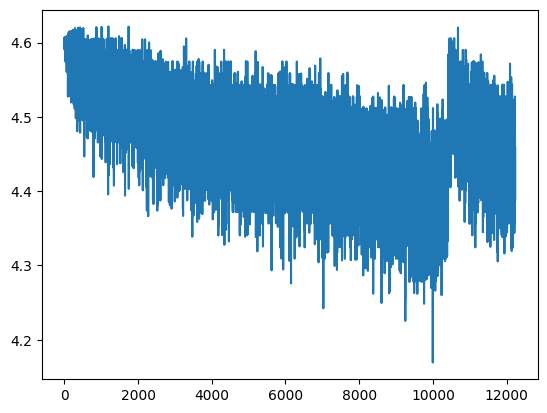

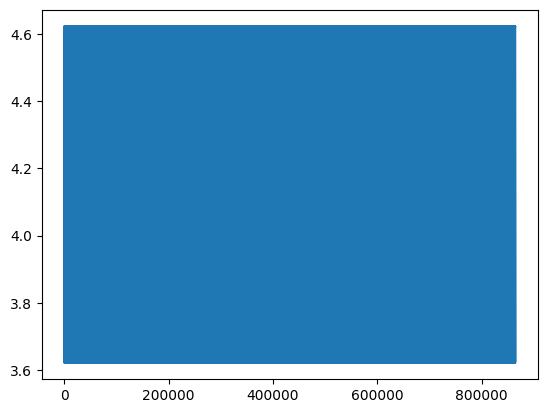

epoch : 22 , acc :  0.1414


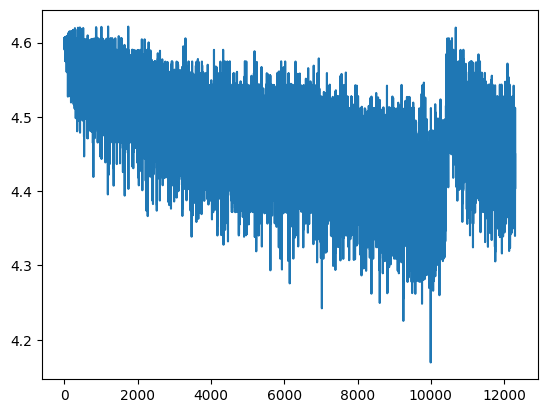

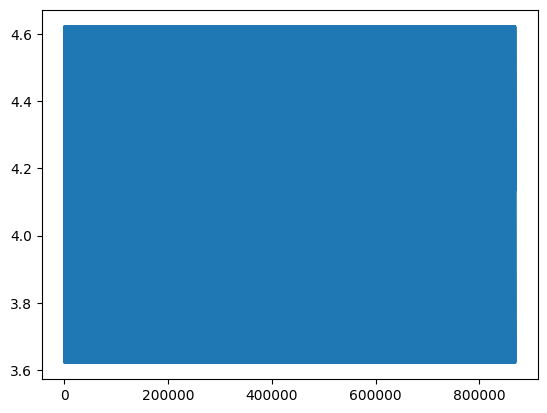

epoch : 23 , acc :  0.1394


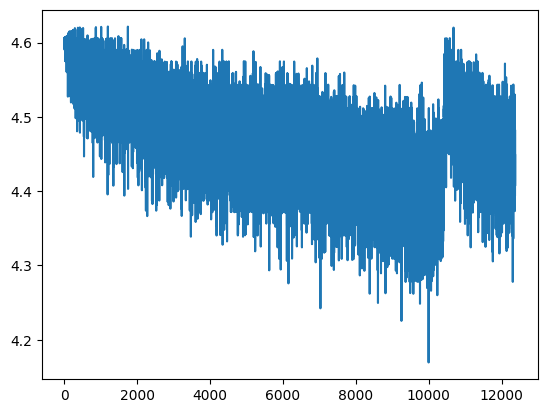

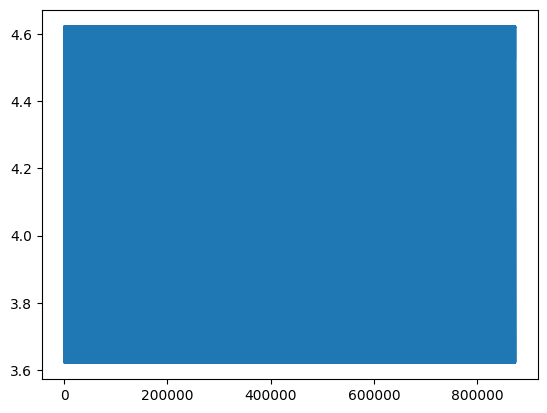

epoch : 24 , acc :  0.1446


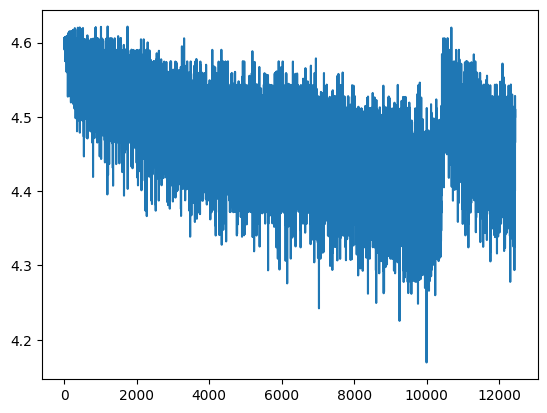

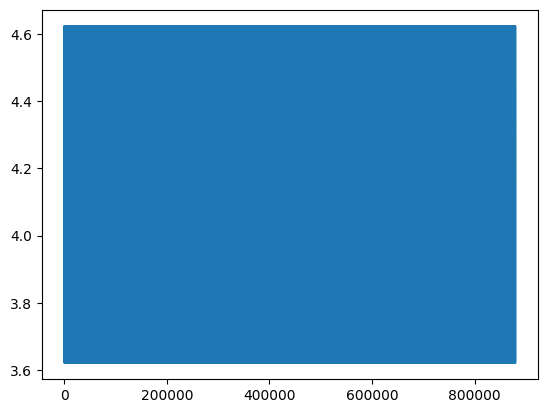

epoch : 25 , acc :  0.142


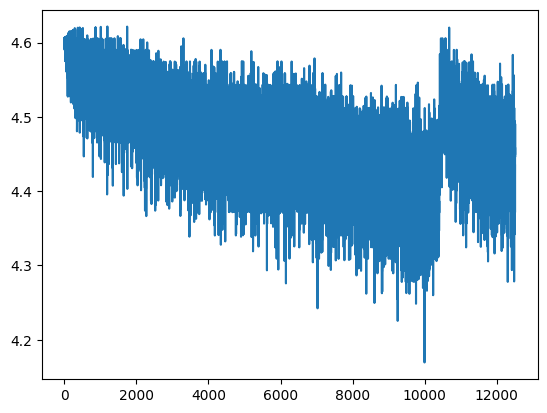

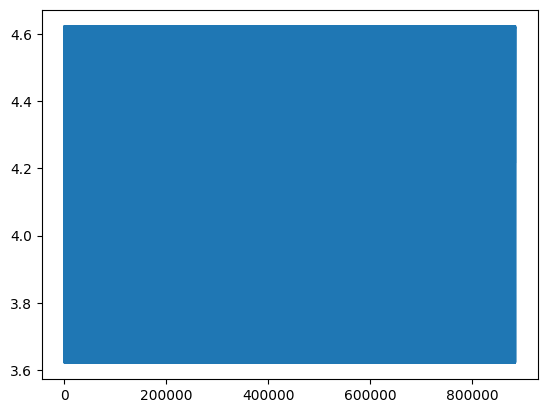

epoch : 26 , acc :  0.142


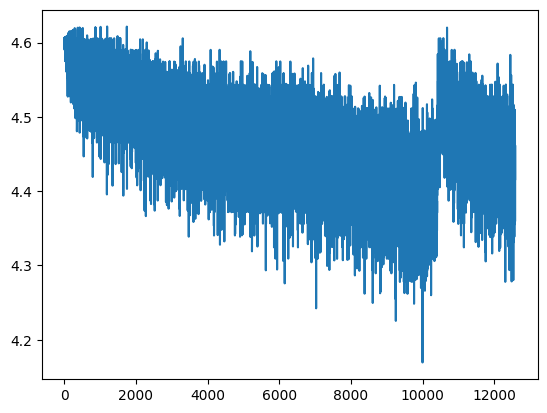

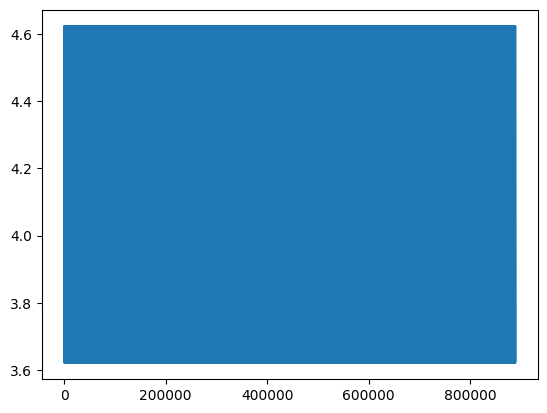

epoch : 27 , acc :  0.1408


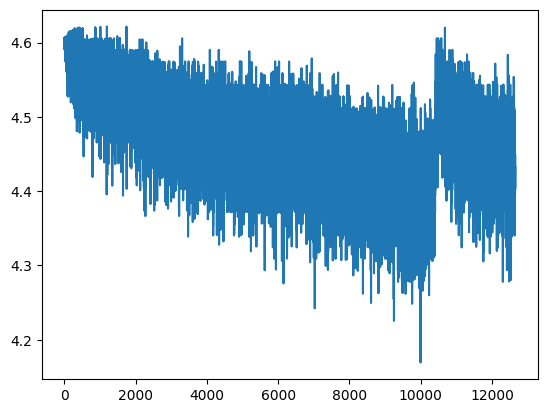

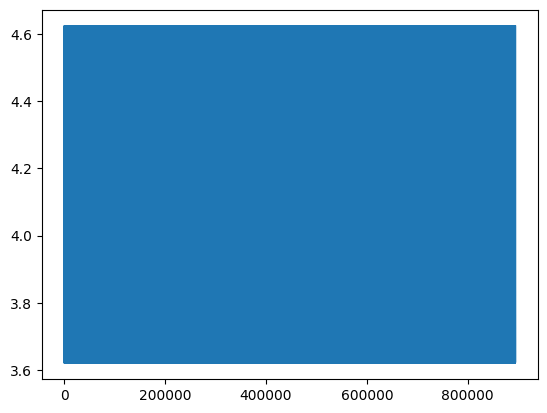

epoch : 28 , acc :  0.1444


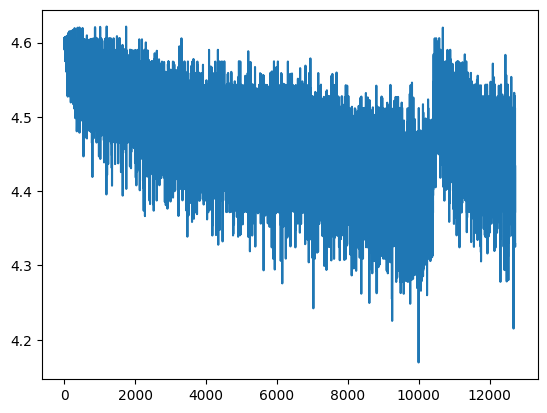

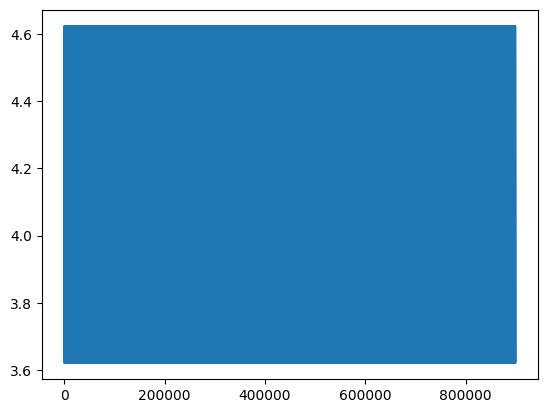

epoch : 29 , acc :  0.1416


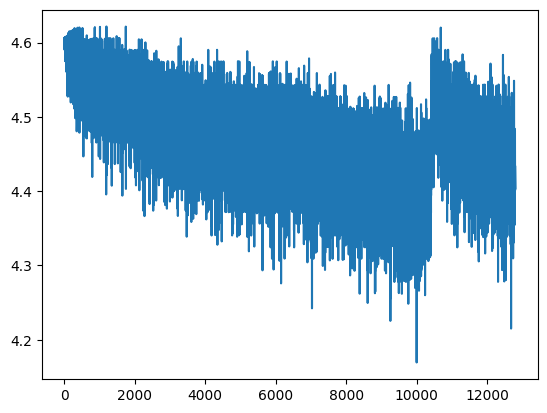

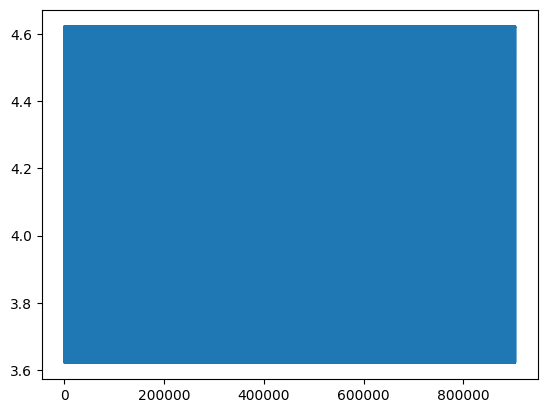

epoch : 30 , acc :  0.1412


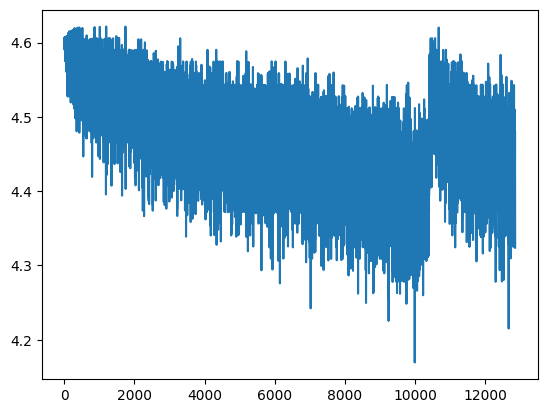

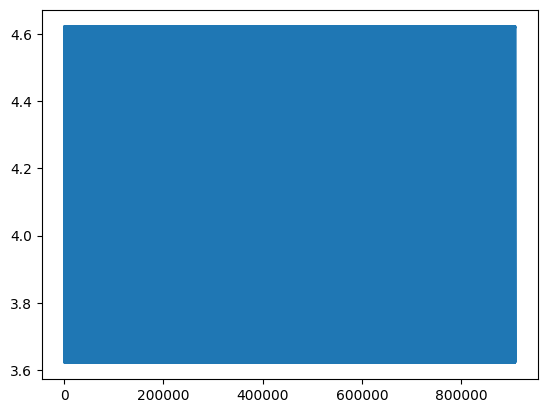

epoch : 31 , acc :  0.1442


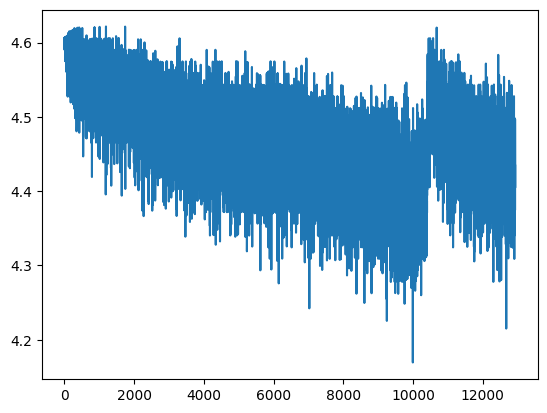

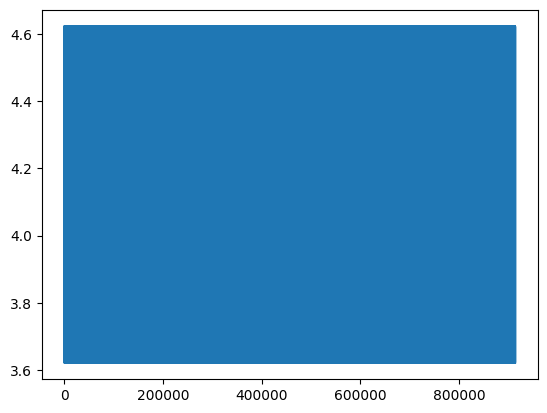

epoch : 32 , acc :  0.1446


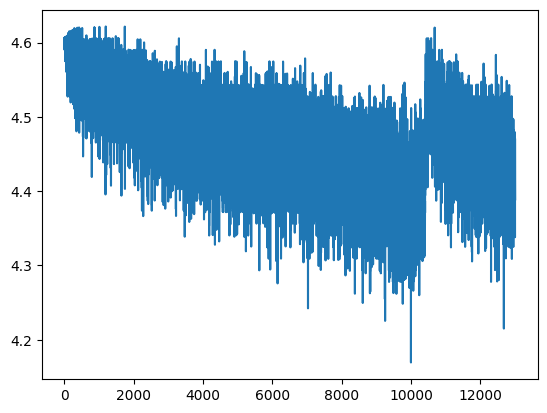

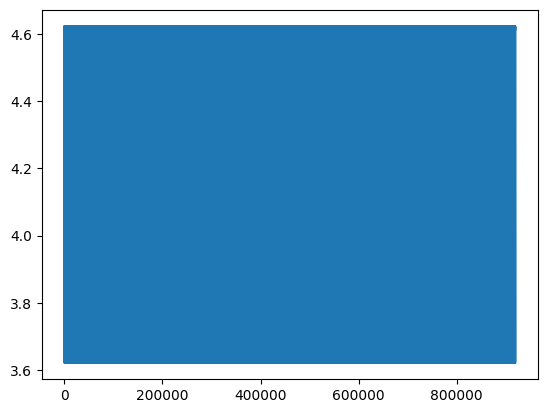

epoch : 33 , acc :  0.1452


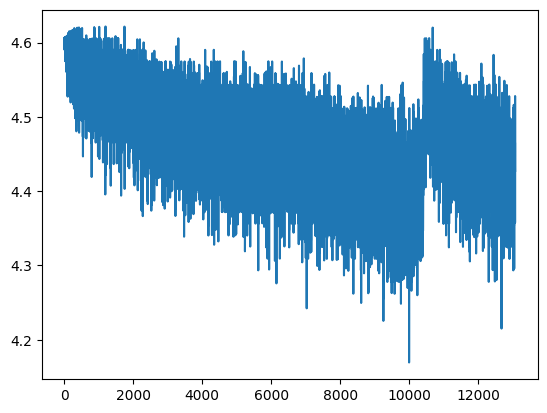

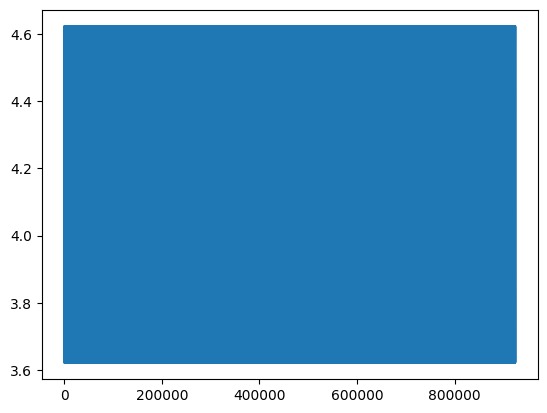

epoch : 34 , acc :  0.147


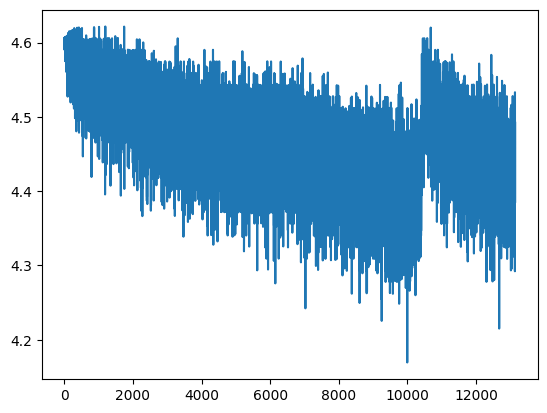

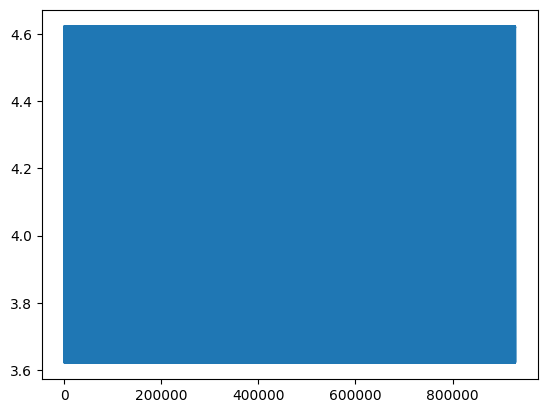

epoch : 35 , acc :  0.1412


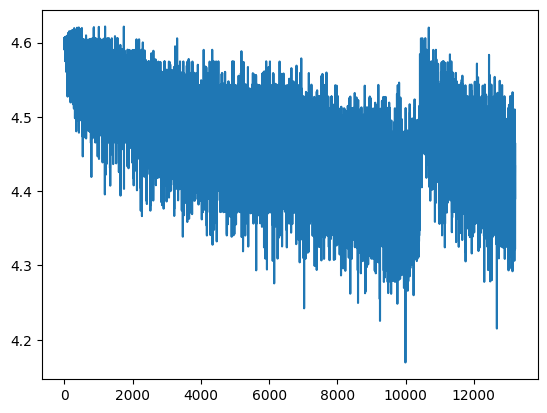

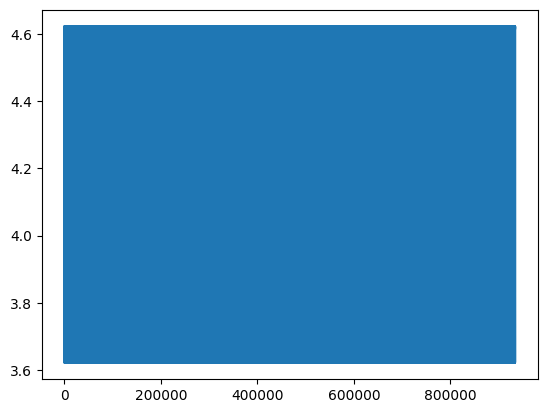

epoch : 36 , acc :  0.145


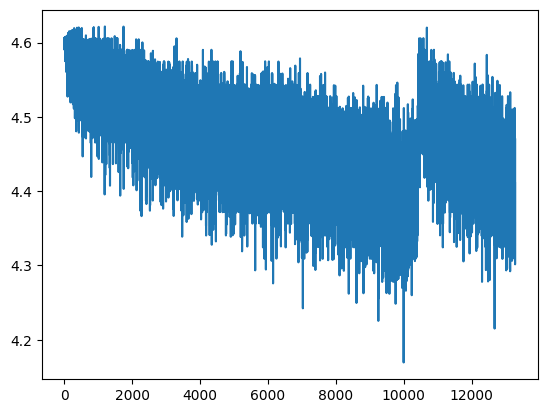

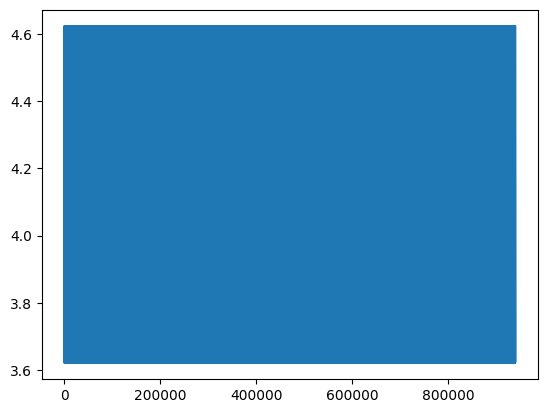

epoch : 37 , acc :  0.1432


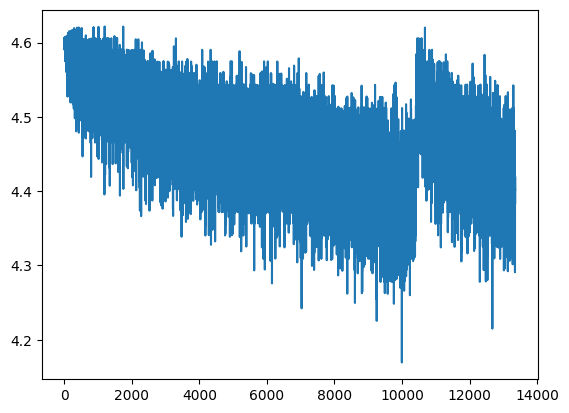

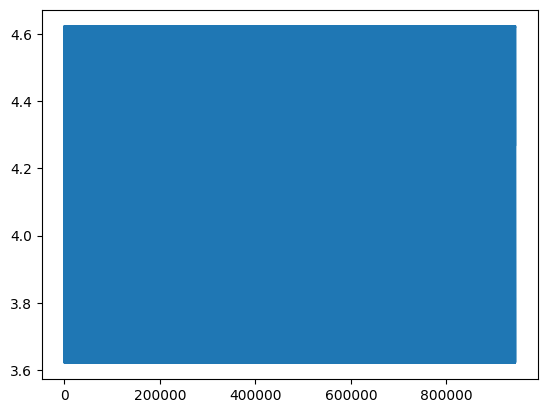

epoch : 38 , acc :  0.1454


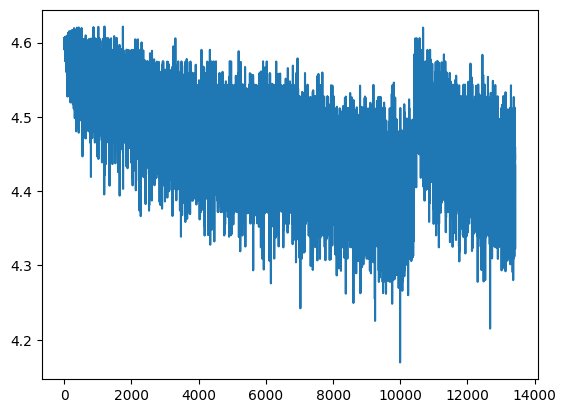

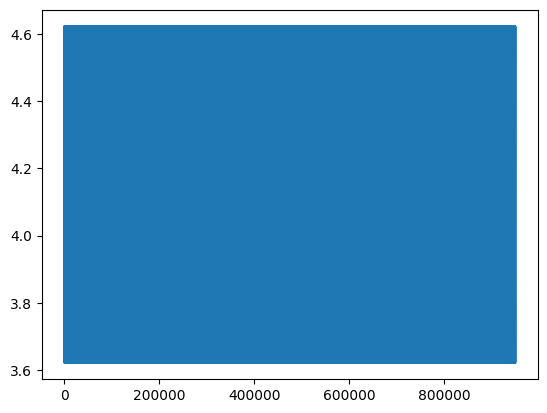

epoch : 39 , acc :  0.1444


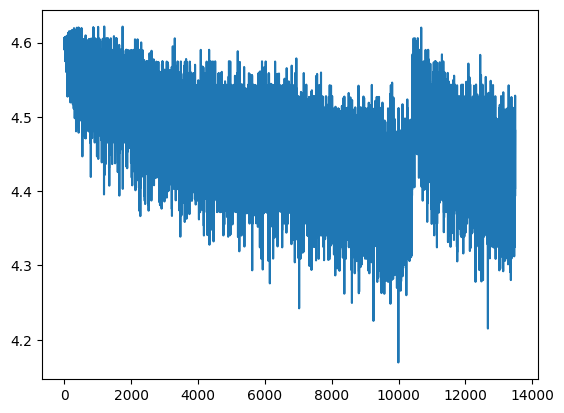

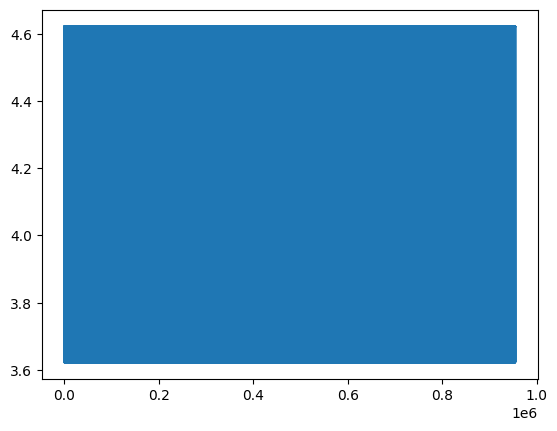

epoch : 40 , acc :  0.1436


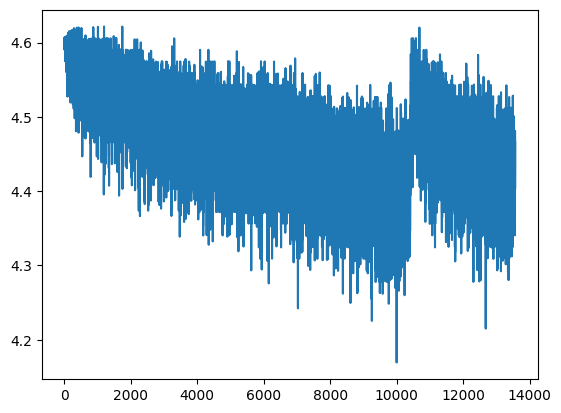

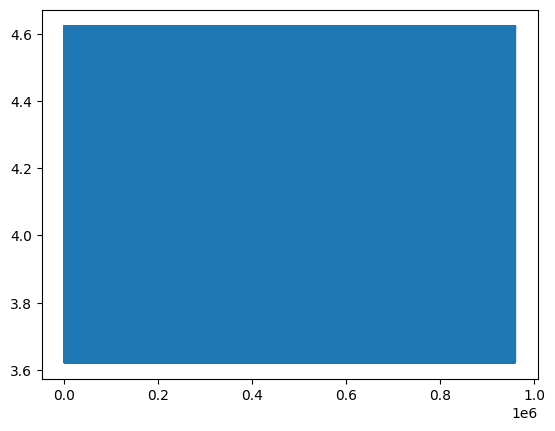

epoch : 41 , acc :  0.1402


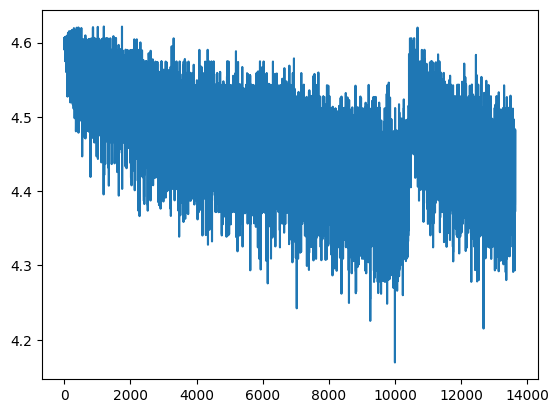

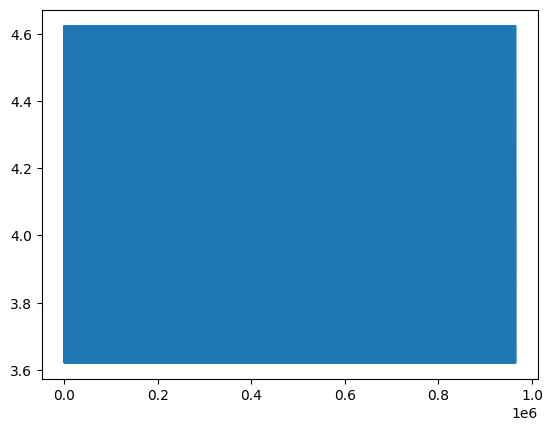

epoch : 42 , acc :  0.1436


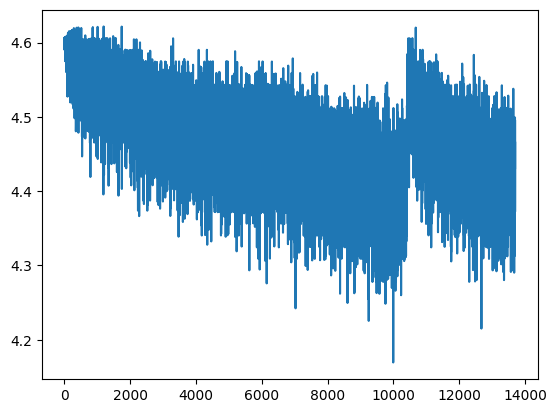

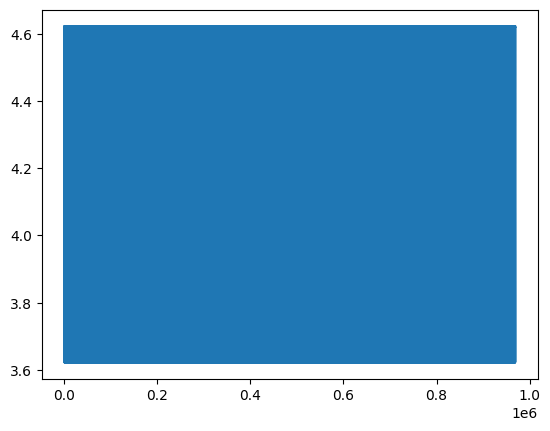

epoch : 43 , acc :  0.14


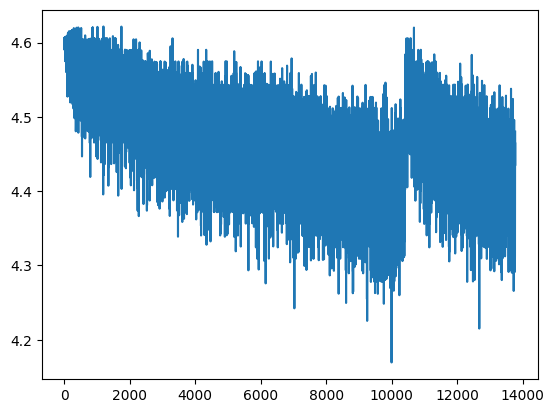

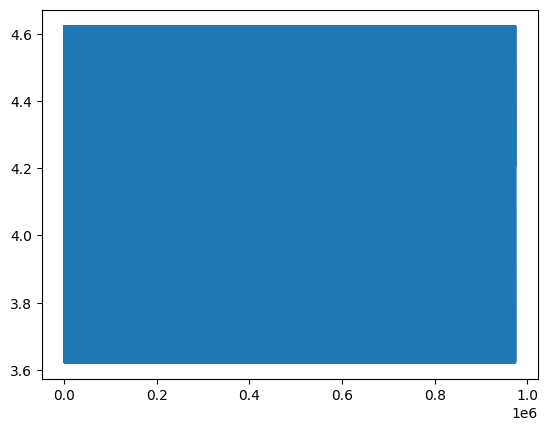

epoch : 44 , acc :  0.1464


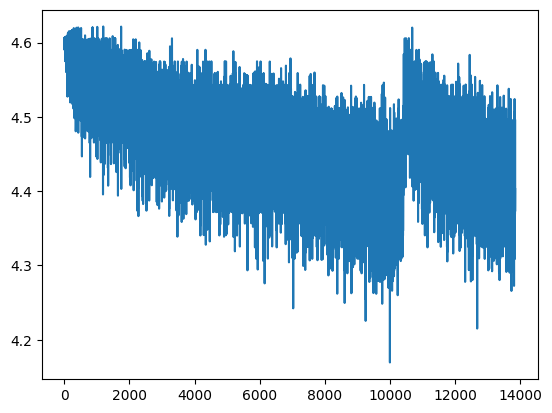

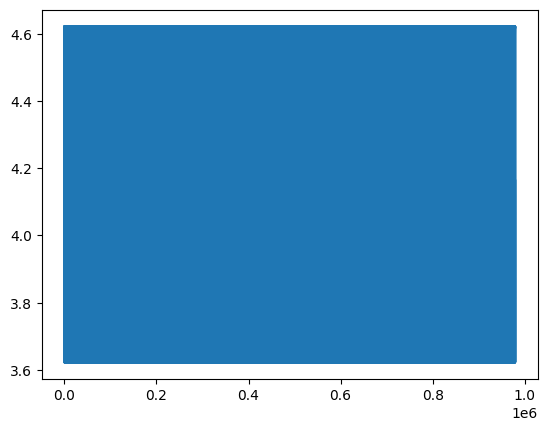

epoch : 45 , acc :  0.1478


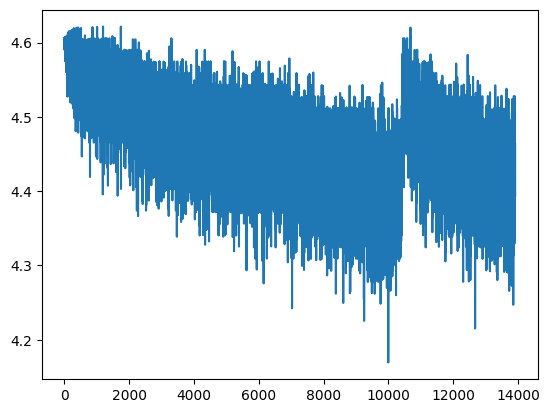

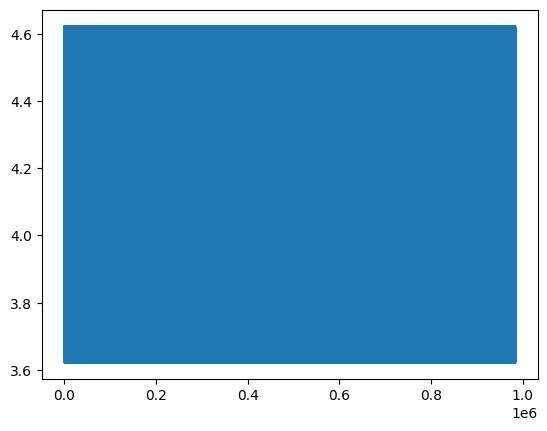

epoch : 46 , acc :  0.144


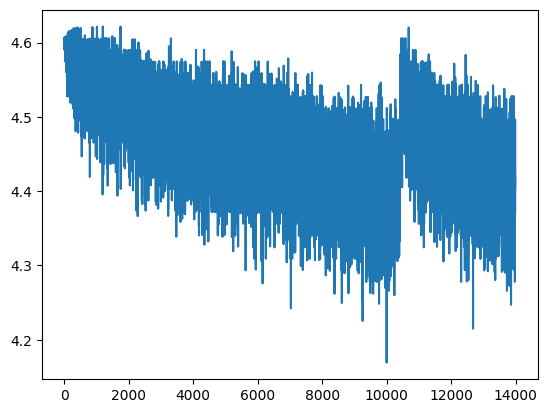

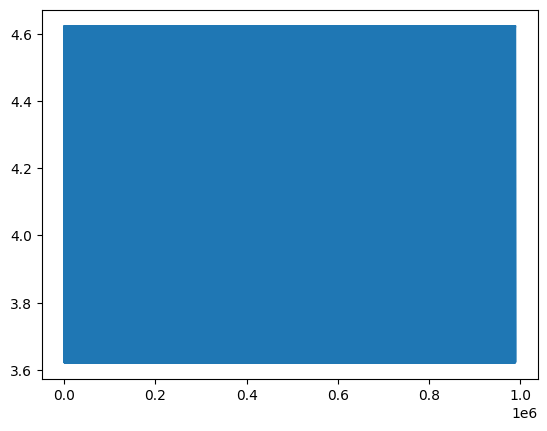

epoch : 47 , acc :  0.1456


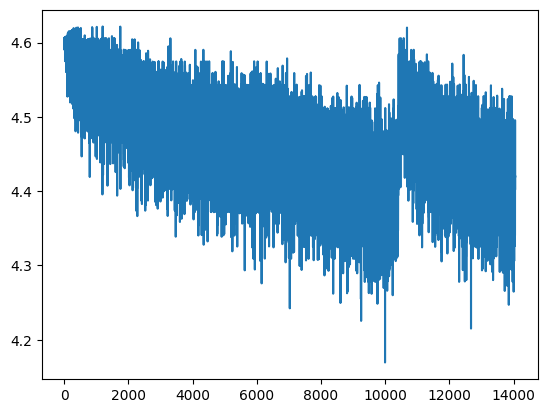

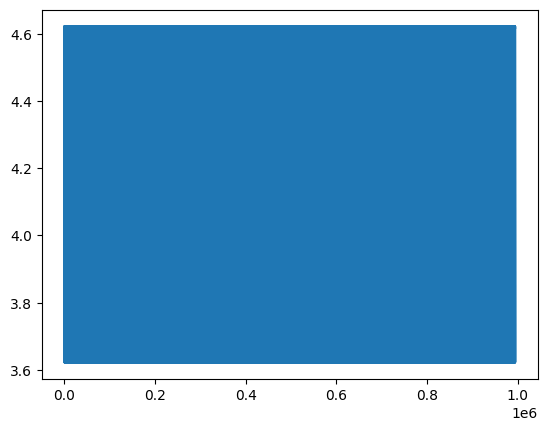

epoch : 48 , acc :  0.145


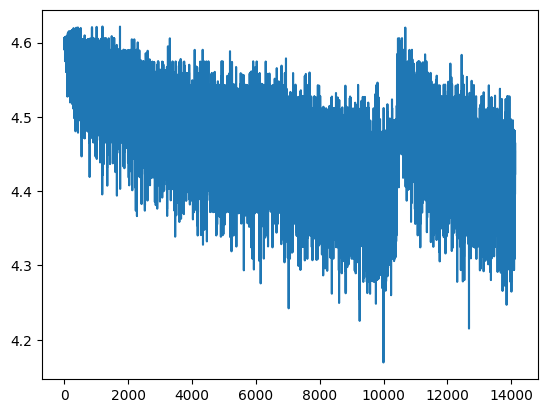

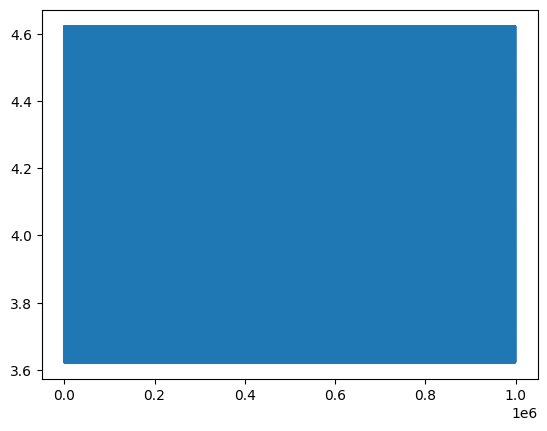

epoch : 49 , acc :  0.1442


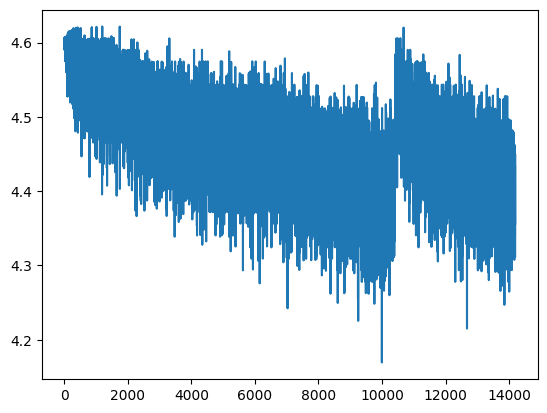

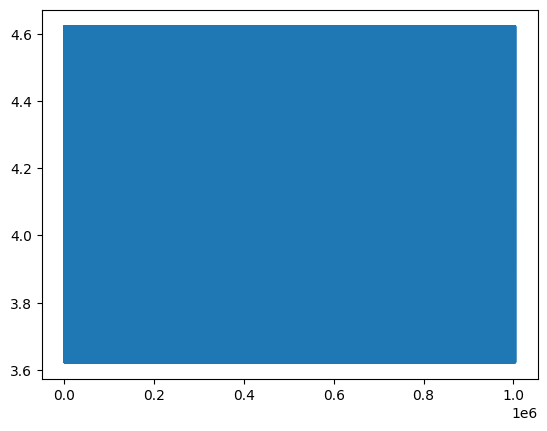

epoch : 50 , acc :  0.143


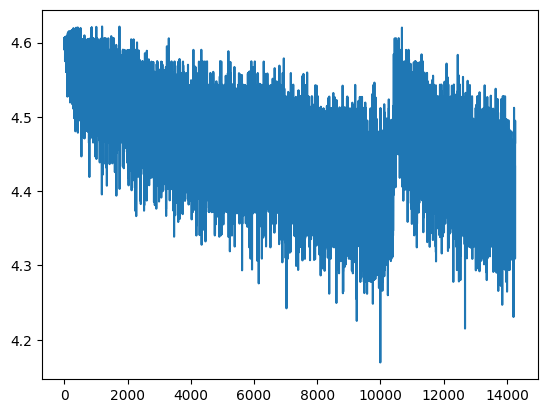

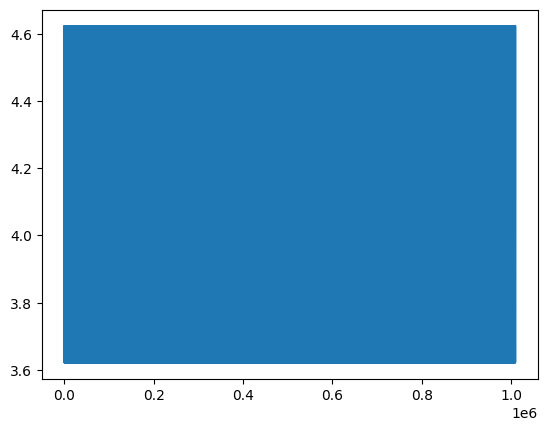

epoch : 51 , acc :  0.1434


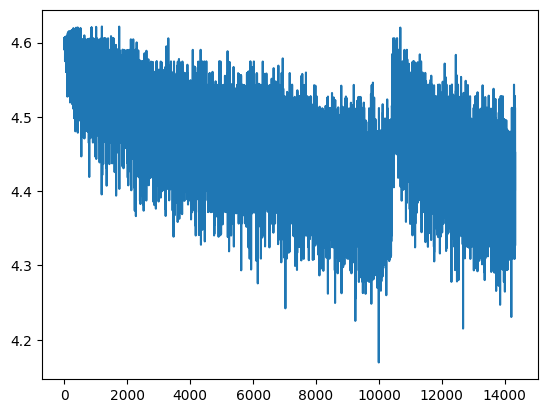

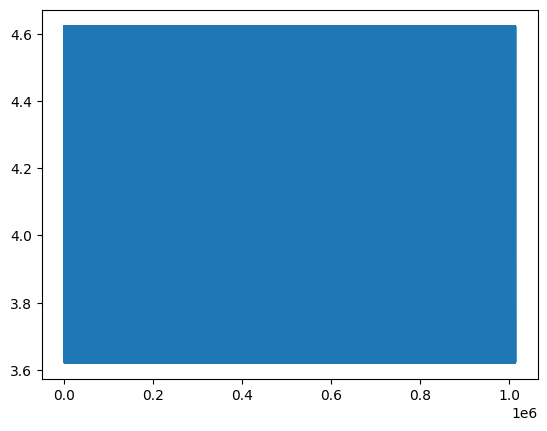

epoch : 52 , acc :  0.1448


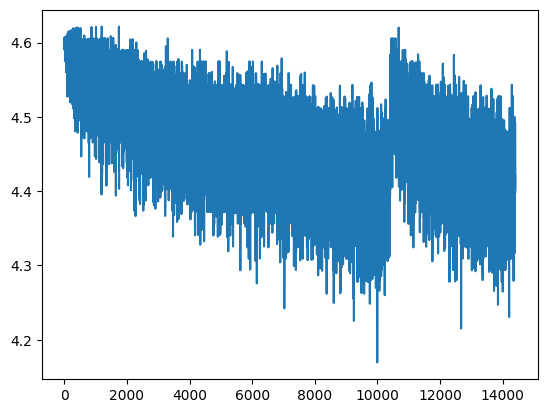

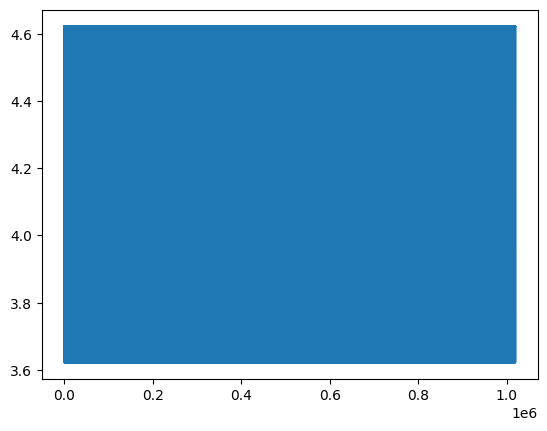

epoch : 53 , acc :  0.1412


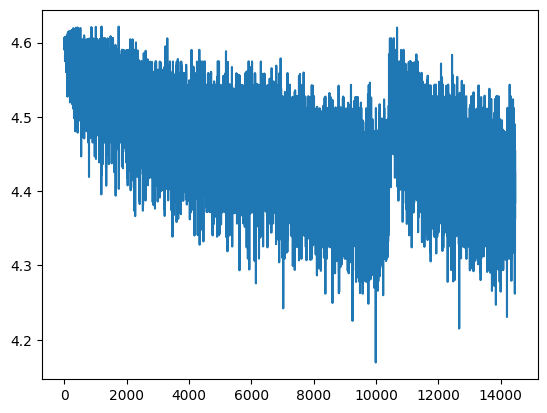

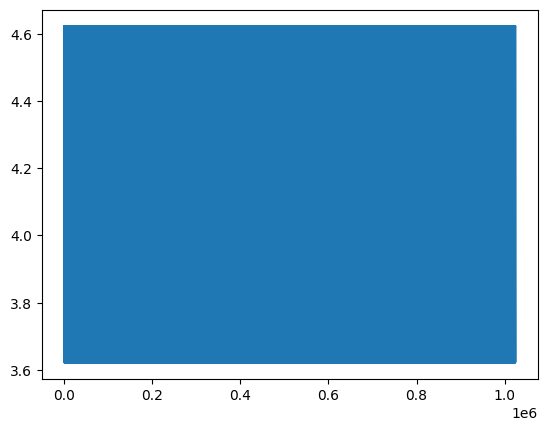

epoch : 54 , acc :  0.1452


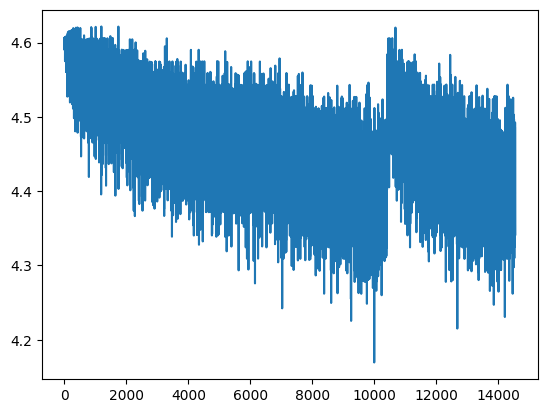

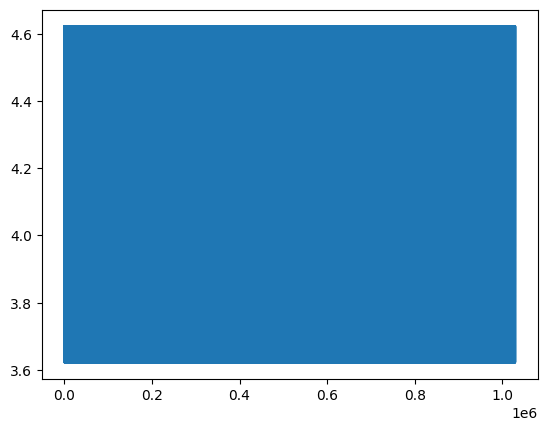

epoch : 55 , acc :  0.144


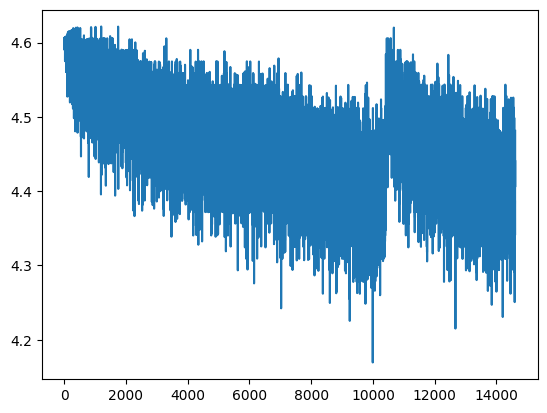

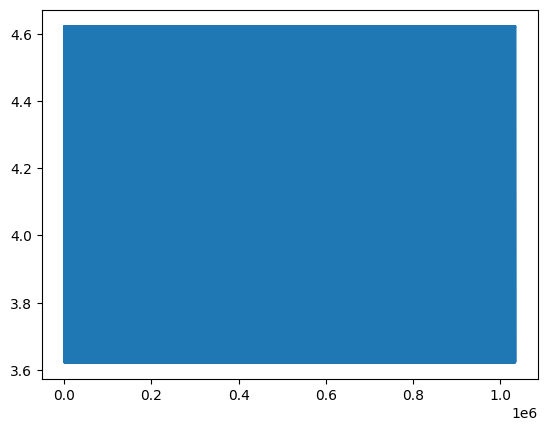

epoch : 56 , acc :  0.1422


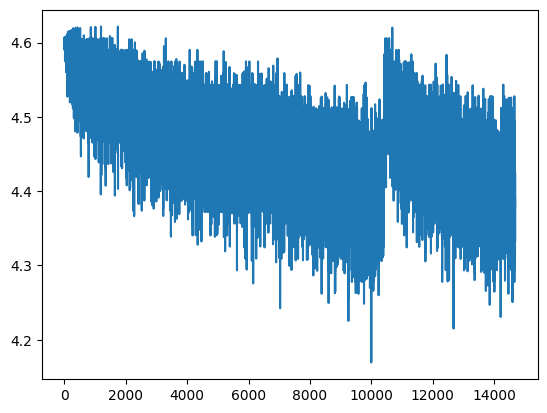

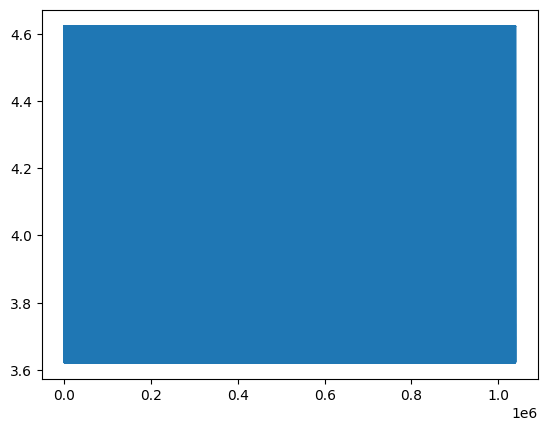

epoch : 57 , acc :  0.1424


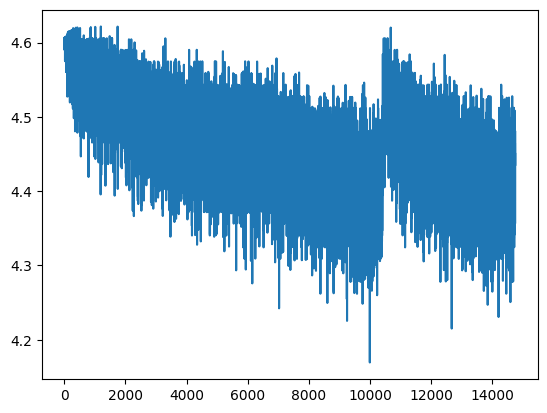

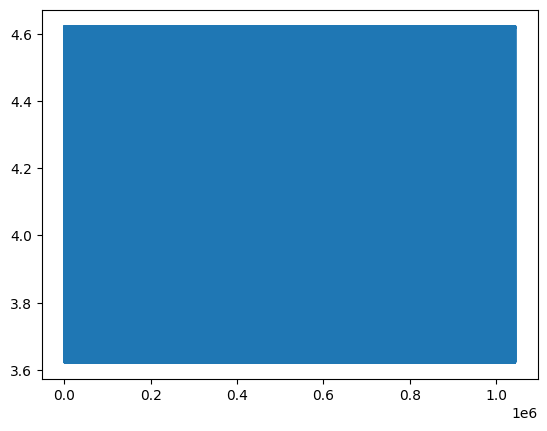

epoch : 58 , acc :  0.145


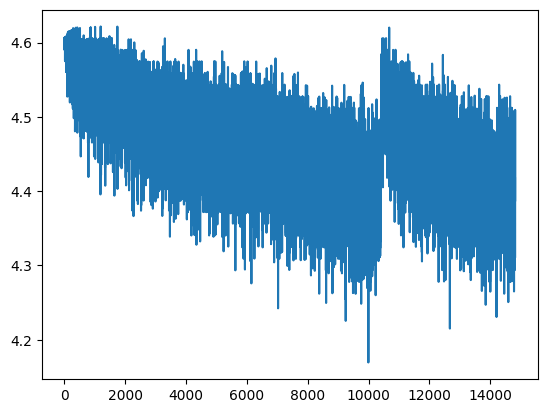

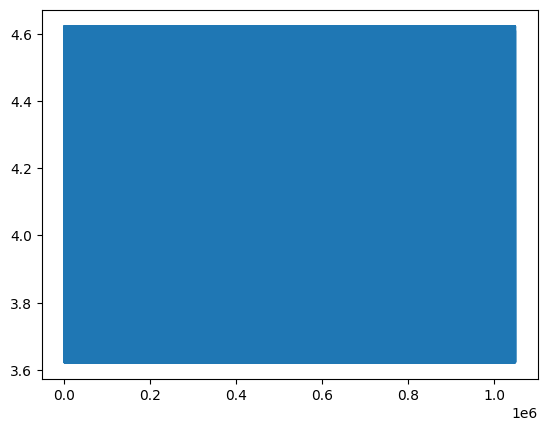

epoch : 59 , acc :  0.1396


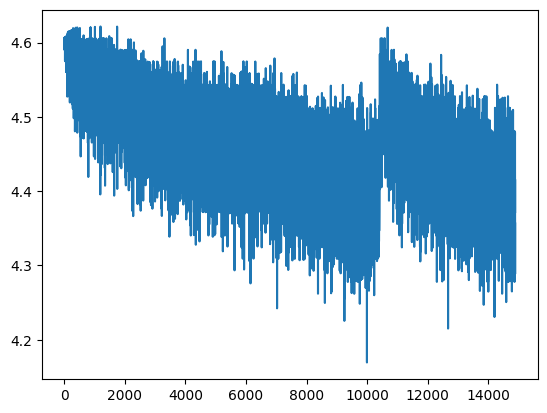

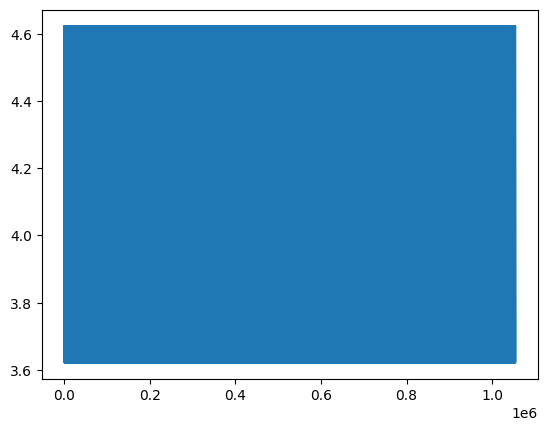

epoch : 60 , acc :  0.1444


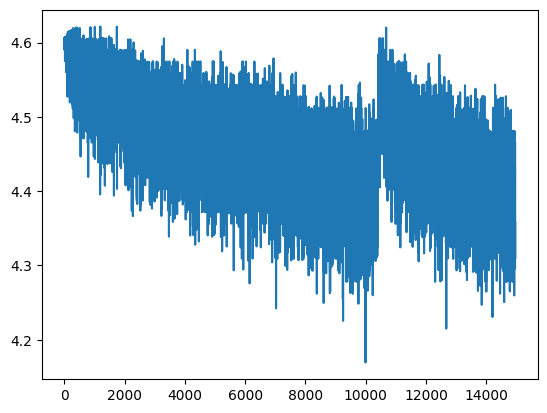

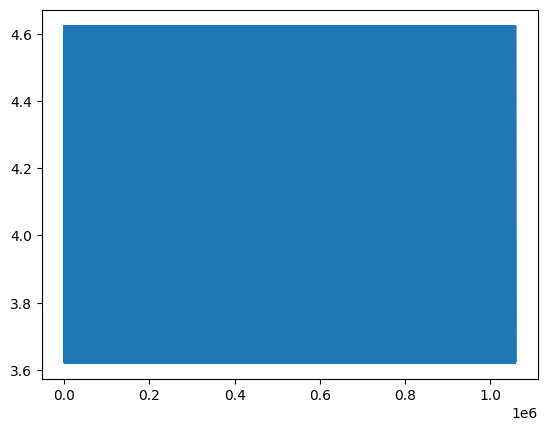

epoch : 61 , acc :  0.143


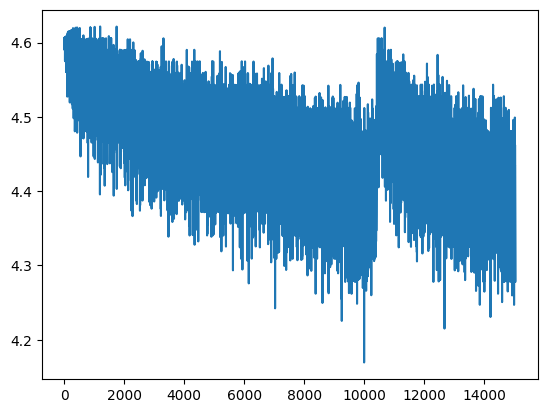

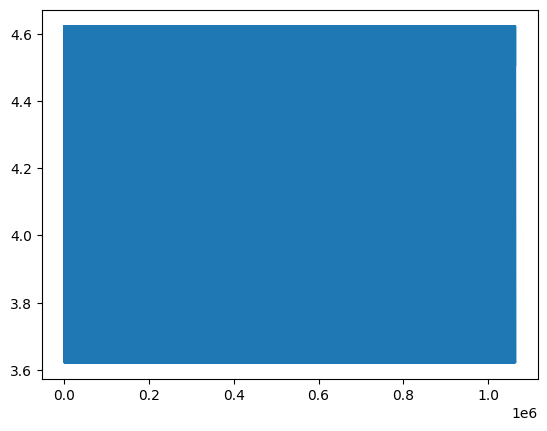

epoch : 62 , acc :  0.1388


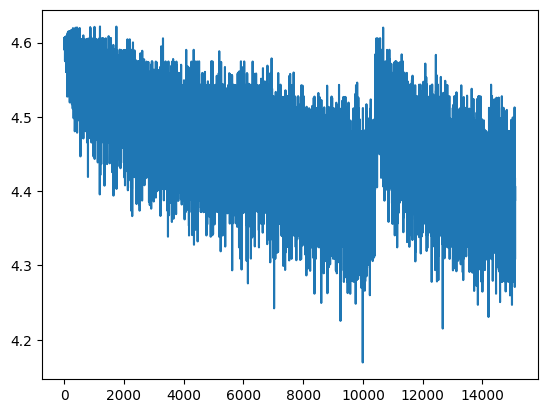

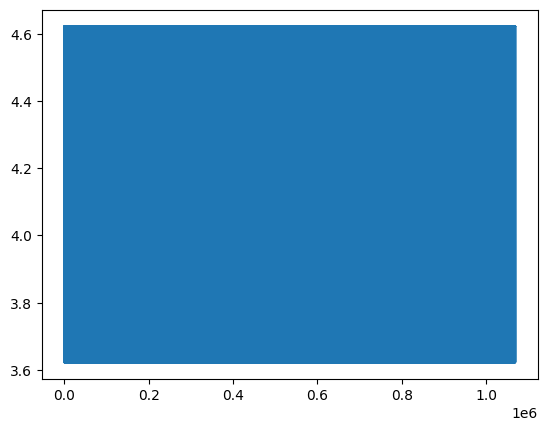

epoch : 63 , acc :  0.1438


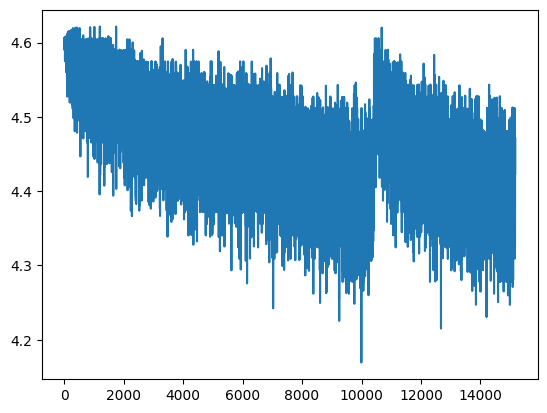

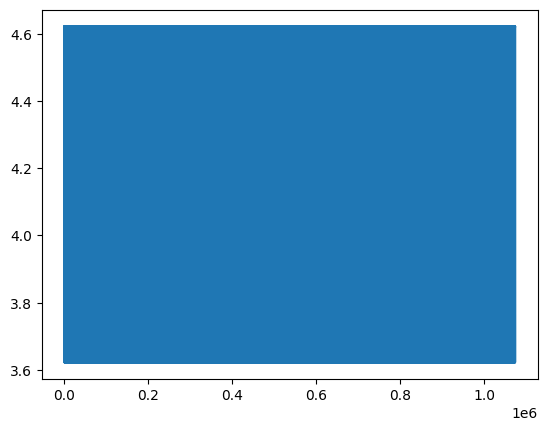

epoch : 64 , acc :  0.1476


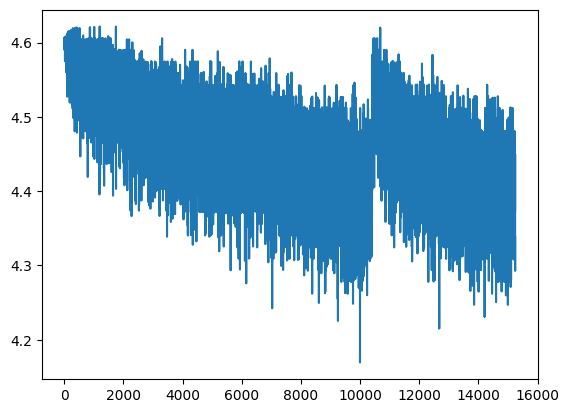

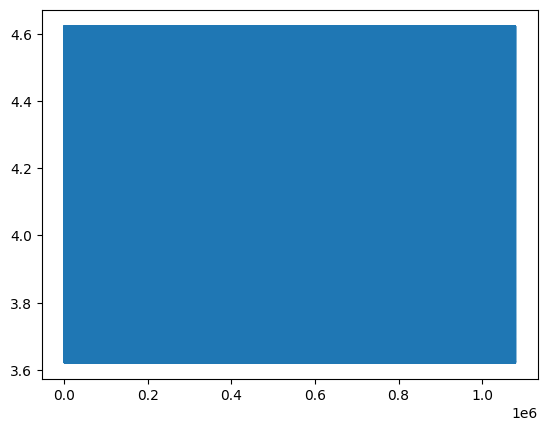

epoch : 65 , acc :  0.1462


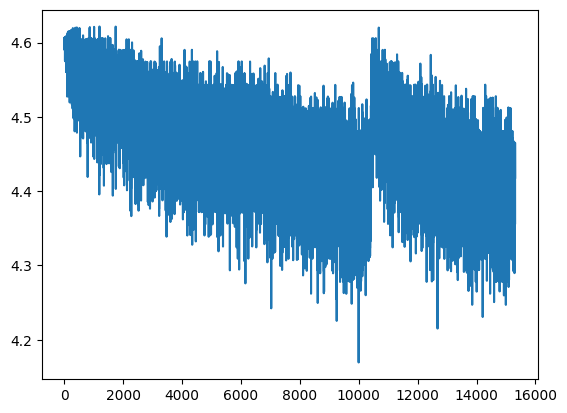

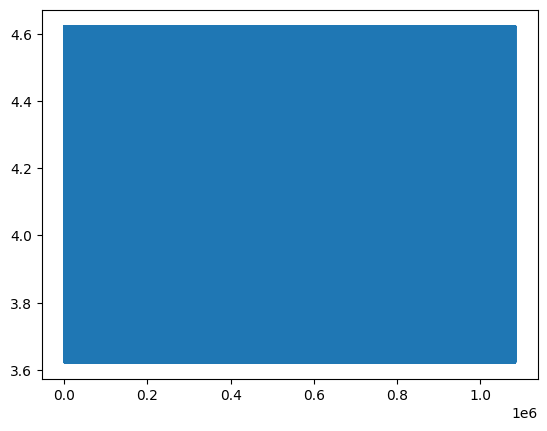

epoch : 66 , acc :  0.1424


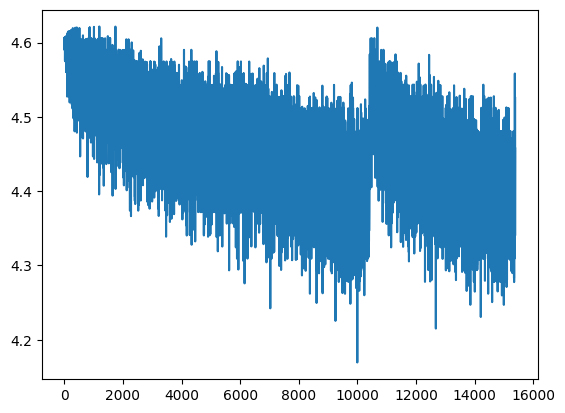

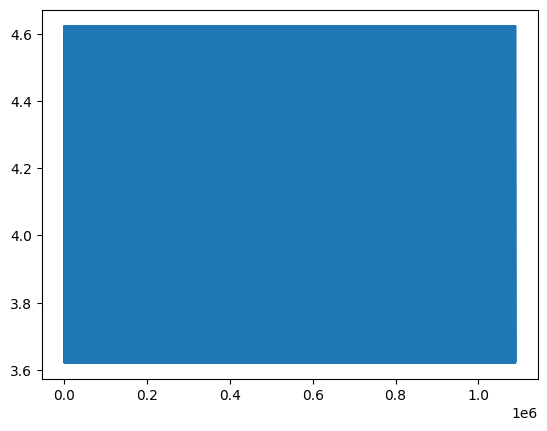

epoch : 67 , acc :  0.1448


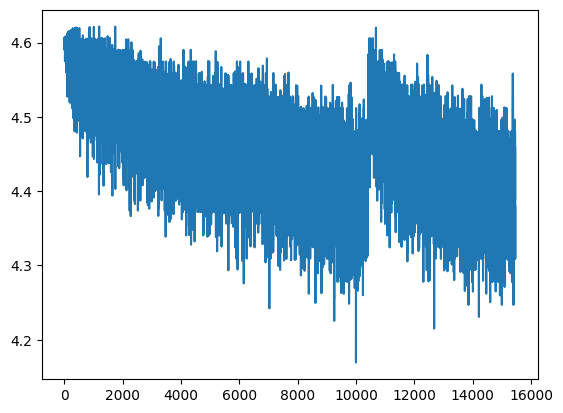

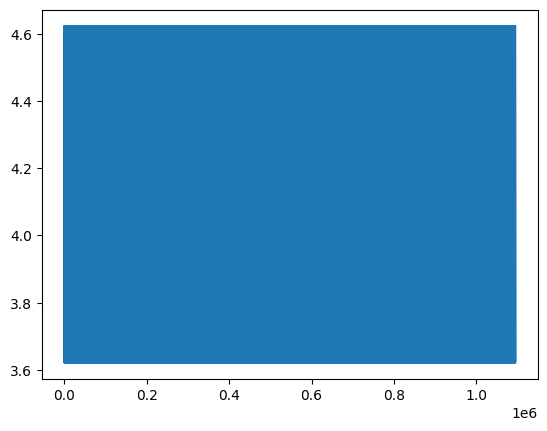

epoch : 68 , acc :  0.1474


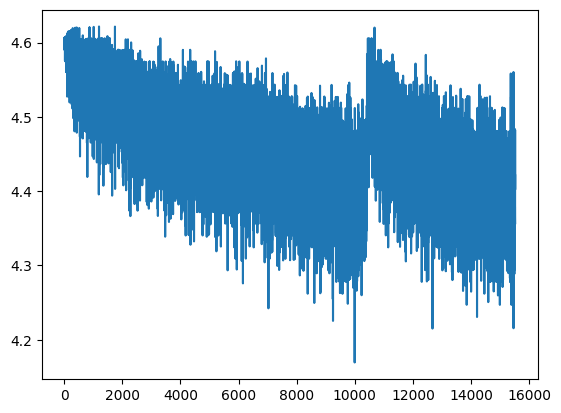

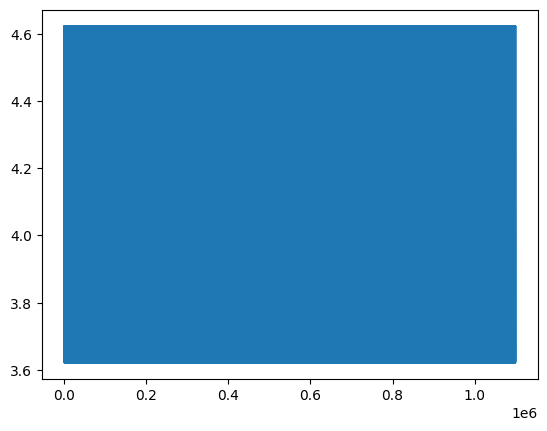

epoch : 69 , acc :  0.148


In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.06)

for epoch in range(70):
    model.train()
    i=0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, _ = data
        inputs = inputs.float().to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # loss변화 확인용
        i+=1
        if not(i%10):
          tlosses.append(loss)



    correct, all_data = 0,0

    pLoss = torch.tensor(tlosses).cpu()
    plt.plot(pLoss)
    plt.show()
#

    model.eval()
    for data in val_loader:
        with torch.no_grad():
            inputs, labels, _ = data
            inputs = inputs.float().to(device)
            labels = labels.to(device)

            output = model(inputs)

            correct += torch.sum(torch.argmax(output, dim=1) == labels).item()
            all_data += len(labels)


            vlosses.append(criterion(output, labels))

    vLoss = torch.tensor(vlosses).cpu()
    plt.plot(vLoss)
    plt.show()
    print("epoch :", epoch,", acc : ", correct / all_data)



### train

In [19]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cifar-100-python/model_weights (2).pth'))

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')